This notebook details the first round of results I will get from the single horseshoebat call measurements. Aditya had identified a single call from all the succesfully matched annotations from 2018-08-17 3-4am. 

There are much fewer multi bat instances than single bat instances, and so we decided to boost the multi bat calls by selectively adding multi-bat annotations from 2-3 and 5-6am. In the final dataset of course, selected calls from even single bat situations will be included. 

Now after having written a code that seems to do a relatively good job of segmenting and measuring parts of a single bat call - I'm going to run it en masse on many more single bat calls - and see how it goes!

--Thejasvi Beleyur, 
MPI for Ornithology, Seewiesen

Last updated 2020-02-13

In [1]:
import glob
import os
import sys 
sys.path.append('../measure_CF_calls/')

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal 
import soundfile as sf

In [2]:
from  measure_single_horseshoe_bat_call import measure_hbc_call, make_overview_figure, dB

In [3]:
all_matched_audio = '/media/tbeleyur/THEJASVI_DATA_BACKUP_3/Aditya_annotations_single_call_measurements/'
matched_audio_folder = os.path.join(all_matched_audio,'real_names/')
audio_files = glob.glob(all_matched_audio+'/real_names/*.WAV')

In [4]:
all_matched_audio

'/media/tbeleyur/THEJASVI_DATA_BACKUP_3/Aditya_annotations_single_call_measurements/'

In [5]:
print(audio_files[:2], len(audio_files))

(['/media/tbeleyur/THEJASVI_DATA_BACKUP_3/Aditya_annotations_single_call_measurements//real_names/matching_annotaudio_Aditya_2018-08-17_34_146.WAV', '/media/tbeleyur/THEJASVI_DATA_BACKUP_3/Aditya_annotations_single_call_measurements//real_names/matching_annotaudio_Aditya_2018-08-17_23_100.WAV'], 348)


In [6]:
video_annotations_34 = pd.read_csv(all_matched_audio+'2018-08-17_3-4am_Aditya.csv')
video_annotations_23 = pd.read_csv(all_matched_audio+'2018-08-17_2-3am_Aditya.csv')
video_annotations_56 = pd.read_csv(all_matched_audio+'2018-08-17_5-6am_Aditya.csv')
print([each.shape[0] for each in [video_annotations_23, video_annotations_34, video_annotations_56]])

[197, 222, 207]


In [7]:
197+222+207

626

In [8]:
all_video_annotations = pd.concat([video_annotations_23, video_annotations_56, video_annotations_34],axis=0).reset_index()
all_video_annotations.head()

index                                         video_path  \
0      0  OrlovaChukaDome_02_20180817_02.00.00-03.00.00[...   
1      1  OrlovaChukaDome_02_20180817_02.00.00-03.00.00[...   
2      2  OrlovaChukaDome_02_20180817_02.00.00-03.00.00[...   
3      3  OrlovaChukaDome_02_20180817_02.00.00-03.00.00[...   
4      4  OrlovaChukaDome_02_20180817_02.00.00-03.00.00[...   

            annotation_id  Sampling minute  timestamp from camera  \
0  Aditya_2018-08-17_23_1                2                      2   
1  Aditya_2018-08-17_23_2                4                      2   
2  Aditya_2018-08-17_23_3                5                      2   
3  Aditya_2018-08-17_23_4                5                      2   
4  Aditya_2018-08-17_23_5                5                      2   

       start_timestamp  start_framenumber        end_timestamp  \
0  2018-08-17 02:02:52                  4  2018-08-17 02:02:53   
1  2018-08-17 02:04:51                 15  2018-08-17 02:04:52   
2  2018-08-17 02:05:24                  9  2018-08-17 02:05:24   
3  2018-08-17 02:05:27                  2  2018-08-17 02:05:27   
4  2018-08-17 02:05:42                 16  2018-08-17 02:05:43   

   end_framenumber  no. of flying bats bat behaviour  \
0               15                   1           NaN   
1               15                   1           NaN   
2               16                   1           NaN   
3               23                   1           NaN   
4                1                   1           NaN   

   strength (1 - strong, 0-weak) weak in (Behaviour Be, Number Bn) Comments  \
0                            1.0                               NaN      NaN   
1                            1.0                               NaN      NaN   
2                            1.0                               NaN      NaN   
3                            1.0                               NaN      NaN   
4                            1.0                               NaN      NaN   

  Details on the comment annotator  
0                    NaN    Aditya  
1                    NaN    Aditya  
2                    NaN    Aditya  
3                    NaN    Aditya  
4                    NaN    Aditya

In [9]:
all_video_annotations.columns

Index([u'index', u'video_path', u'annotation_id', u'Sampling minute',
       u'timestamp from camera', u'start_timestamp', u'start_framenumber',
       u'end_timestamp', u'end_framenumber', u'no. of flying bats',
       u'bat behaviour', u'strength (1 - strong, 0-weak)',
       u'weak in (Behaviour Be, Number Bn)', u'Comments',
       u'Details on the comment', u'annotator'],
      dtype='object')

In [10]:
# all annotations with start and end times of one bat call per matched audio. 
# for 3-4 am this is done with single and multi bat situations
single_calls_34 = pd.read_csv(all_matched_audio+'/Audio Annotation Datasheet_3-4_16.08.18_corrected.csv')

# One bat call for 2-3 am and 5-6am only the multi bat annotations 
# this is done to selectively boost the sample size. 
calls_56 = pd.read_csv(all_matched_audio+'Multibat events_5-6_16.08.18.csv')
calls_23 = pd.read_csv(all_matched_audio+'Multiple Bats_2018-08-16_23_am_corrected.csv')

#combine them all
single_calls = pd.concat([single_calls_34, calls_23, calls_56], axis=0).reset_index(drop=True)

/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [11]:
single_calls.columns

Index([u'Comments', u'Direction', u'No._of_ms_whole_screen', u'SNR(dB RMS)',
       u'Silent_period_Start', u'Silent_period_end', u'Unnamed: 1',
       u'Unnamed: 11', u'Unnamed: 12', u'Unnamed: 13', u'Unnamed: 14',
       u'Unnamed: 15', u'Unnamed: 16', u'Unnamed: 17', u'Unnamed: 18',
       u'audio_annotation_file', u'call_end_time', u'call_start_time',
       u'fm2_dbrms', u'fm2_end_time', u'fm2_start_time',
       u'search_start_time(s)', u'start_random_point'],
      dtype='object')

In [12]:
single_calls.tail()


Comments Direction  \
191                 Prominent myotis calls + HSB calls         L   
192          Two bat situation- Prominent M+ HSB calls         R   
193        Multi bat situation- Prominent M+ HSB calls         R   
194                                   Myotis+HSB calls         L   
195  There were only 1-2 loud myotis call. But stil...         R   

     No._of_ms_whole_screen  SNR(dB RMS)  Silent_period_Start  \
191                     NaN          NaN                  NaN   
192                     NaN          NaN                  NaN   
193                     NaN          NaN                  NaN   
194                     NaN          NaN                  NaN   
195                     NaN          NaN                  NaN   

    Silent_period_end  Unnamed: 1  Unnamed: 11  Unnamed: 12  Unnamed: 13  ...  \
191               NaN         NaN          NaN          NaN          NaN  ...   
192               NaN         NaN          NaN          NaN          NaN  ...   
193               NaN         NaN          NaN          NaN          NaN  ...   
194               NaN         NaN          NaN          NaN          NaN  ...   
195               NaN         NaN          NaN          NaN          NaN  ...   

     Unnamed: 17  Unnamed: 18                         audio_annotation_file  \
191          NaN          NaN  matching_annotaudio_Aditya_2018-08-17_56_164   
192          NaN          NaN  matching_annotaudio_Aditya_2018-08-17_56_169   
193          NaN          NaN  matching_annotaudio_Aditya_2018-08-17_56_171   
194          NaN          NaN  matching_annotaudio_Aditya_2018-08-17_56_127   
195          NaN          NaN  matching_annotaudio_Aditya_2018-08-17_56_168   

     call_end_time  call_start_time fm2_dbrms  fm2_end_time  fm2_start_time  \
191            NaN              NaN       NaN           NaN             NaN   
192            NaN              NaN       NaN           NaN             NaN   
193            NaN              NaN       NaN           NaN             NaN   
194            NaN              NaN       NaN           NaN             NaN   
195            NaN              NaN       NaN           NaN             NaN   

     search_start_time(s)  start_random_point  
191                   NaN                14.0  
192                   NaN                20.0  
193                   NaN                41.0  
194                   NaN                29.0  
195                   NaN                71.0  

[5 rows x 23 columns]

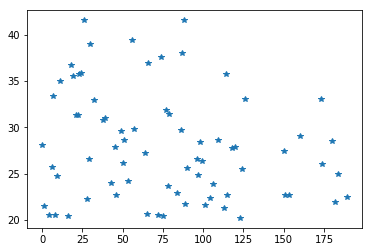

In [13]:
plt.figure()
plt.plot(single_calls['SNR(dB RMS)'],'*')

In [14]:
# remove all those audiofiles without a good call in them
with_geq_1_call = single_calls[~np.isnan(single_calls['call_start_time'])].reset_index(drop=True)
with_geq_1_call.head()

Comments Direction  \
0                                             NaN         R   
1                                             NaN         L   
2  There is some echo present just after the call         R   
3  There is some echo present just after the call         R   
4                                             NaN         L   

   No._of_ms_whole_screen  SNR(dB RMS)  Silent_period_Start Silent_period_end  \
0                    60.0        28.15                2.009             2.027   
1                    60.0        21.53                0.306            0.5821   
2                    80.0        20.56                1.135             1.151   
3                    75.0        25.69                0.039             0.051   
4                    55.0        33.38                3.129             3.141   

   Unnamed: 1  Unnamed: 11  Unnamed: 12  Unnamed: 13  ...  Unnamed: 17  \
0        0.33          NaN          NaN          NaN  ...          NaN   
1        0.76          NaN          NaN          NaN  ...          NaN   
2        0.52          NaN          NaN          NaN  ...          NaN   
3        0.74          NaN          NaN          NaN  ...          NaN   
4        0.59          NaN          NaN          NaN  ...          NaN   

   Unnamed: 18                        audio_annotation_file  call_end_time  \
0          NaN   matching_annotaudio_Aditya_2018-08-17_34_1          2.050   
1          NaN   matching_annotaudio_Aditya_2018-08-17_34_2          0.328   
2          NaN   matching_annotaudio_Aditya_2018-08-17_34_7          1.176   
3          NaN  matching_annotaudio_Aditya_2018-08-17_34_12          0.083   
4          NaN  matching_annotaudio_Aditya_2018-08-17_34_18          3.120   

   call_start_time fm2_dbrms  fm2_end_time  fm2_start_time  \
0            2.031       NaN           NaN             NaN   
1            0.313       NaN           NaN             NaN   
2            1.154       NaN           NaN             NaN   
3            0.054       NaN           NaN             NaN   
4            3.064       NaN           NaN             NaN   

   search_start_time(s)  start_random_point  
0                0.7920                33.0  
1                0.6992                76.0  
2                0.6448                52.0  
3                1.6872                74.0  
4                2.0296                59.0  

[5 rows x 23 columns]

In [15]:
with_geq_1_call.iloc[11:15,:]

Comments Direction  No._of_ms_whole_screen  SNR(dB RMS)  \
11      NaN         R                    70.0        31.37   
12      NaN         L                    60.0        31.32   
13      NaN         R                    60.0        35.75   
14      NaN         R                    60.0        35.88   

    Silent_period_Start Silent_period_end  Unnamed: 1  Unnamed: 11  \
11                0.230             0.239        0.81          NaN   
12                0.318             0.332        0.29          NaN   
13                0.287             0.301        0.08          NaN   
14                0.779             0.794        0.55          NaN   

    Unnamed: 12  Unnamed: 13  ...  Unnamed: 17  Unnamed: 18  \
11          NaN          NaN  ...          NaN          NaN   
12          NaN          NaN  ...          NaN          NaN   
13          NaN          NaN  ...          NaN          NaN   
14          NaN          NaN  ...          NaN          NaN   

                          audio_annotation_file  call_end_time  \
11  matching_annotaudio_Aditya_2018-08-17_34_39          0.039   
12  matching_annotaudio_Aditya_2018-08-17_34_40          0.359   
13  matching_annotaudio_Aditya_2018-08-17_34_41          0.352   
14  matching_annotaudio_Aditya_2018-08-17_34_43          1.017   

    call_start_time fm2_dbrms  fm2_end_time  fm2_start_time  \
11            0.016       NaN           NaN             NaN   
12            0.339       NaN           NaN             NaN   
13            0.302       NaN           NaN             NaN   
14            0.992       NaN           NaN             NaN   

    search_start_time(s)  start_random_point  
11                0.2268                81.0  
12                0.3625                29.0  
13                0.0448                 8.0  
14                0.9240                55.0  

[4 rows x 23 columns]

In [16]:
output_folder = os.path.join(all_matched_audio,'call_measurement_outputs/')

In [17]:
output_folder

'/media/tbeleyur/THEJASVI_DATA_BACKUP_3/Aditya_annotations_single_call_measurements/call_measurement_outputs/'

In [18]:
matched_audio_folder

'/media/tbeleyur/THEJASVI_DATA_BACKUP_3/Aditya_annotations_single_call_measurements/real_names/'

In [19]:
all_msmts = []
failed_msmts = []

In [20]:
matched_audio_folder

'/media/tbeleyur/THEJASVI_DATA_BACKUP_3/Aditya_annotations_single_call_measurements/real_names/'

matching_annotaudio_Aditya_2018-08-17_34_1


/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


matching_annotaudio_Aditya_2018-08-17_34_2
matching_annotaudio_Aditya_2018-08-17_34_7


/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 4096 is greater than input length  = 4036, using nperseg = 4036
  .format(nperseg, input_length))


matching_annotaudio_Aditya_2018-08-17_34_12
matching_annotaudio_Aditya_2018-08-17_34_18
matching_annotaudio_Aditya_2018-08-17_34_19
matching_annotaudio_Aditya_2018-08-17_34_20
matching_annotaudio_Aditya_2018-08-17_34_22
matching_annotaudio_Aditya_2018-08-17_34_32
matching_annotaudio_Aditya_2018-08-17_34_35
matching_annotaudio_Aditya_2018-08-17_34_36
matching_annotaudio_Aditya_2018-08-17_34_39
matching_annotaudio_Aditya_2018-08-17_34_40
matching_annotaudio_Aditya_2018-08-17_34_41
matching_annotaudio_Aditya_2018-08-17_34_43
matching_annotaudio_Aditya_2018-08-17_34_49
matching_annotaudio_Aditya_2018-08-17_34_52
matching_annotaudio_Aditya_2018-08-17_34_53
matching_annotaudio_Aditya_2018-08-17_34_54
matching_annotaudio_Aditya_2018-08-17_34_56
matching_annotaudio_Aditya_2018-08-17_34_64
matching_annotaudio_Aditya_2018-08-17_34_65


/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


matching_annotaudio_Aditya_2018-08-17_34_69
matching_annotaudio_Aditya_2018-08-17_34_71
matching_annotaudio_Aditya_2018-08-17_34_72
matching_annotaudio_Aditya_2018-08-17_34_77
matching_annotaudio_Aditya_2018-08-17_34_78
matching_annotaudio_Aditya_2018-08-17_34_79
matching_annotaudio_Aditya_2018-08-17_34_81
matching_annotaudio_Aditya_2018-08-17_34_111


/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 4096 is greater than input length  = 4037, using nperseg = 4037
  .format(nperseg, input_length))


matching_annotaudio_Aditya_2018-08-17_34_120
matching_annotaudio_Aditya_2018-08-17_34_132
matching_annotaudio_Aditya_2018-08-17_34_133
matching_annotaudio_Aditya_2018-08-17_34_134
matching_annotaudio_Aditya_2018-08-17_34_142
matching_annotaudio_Aditya_2018-08-17_34_144
matching_annotaudio_Aditya_2018-08-17_34_145
matching_annotaudio_Aditya_2018-08-17_34_147
matching_annotaudio_Aditya_2018-08-17_34_149
matching_annotaudio_Aditya_2018-08-17_34_151
matching_annotaudio_Aditya_2018-08-17_34_158
matching_annotaudio_Aditya_2018-08-17_34_165
matching_annotaudio_Aditya_2018-08-17_34_168
matching_annotaudio_Aditya_2018-08-17_34_169
matching_annotaudio_Aditya_2018-08-17_34_170
matching_annotaudio_Aditya_2018-08-17_34_171
matching_annotaudio_Aditya_2018-08-17_34_201
matching_annotaudio_Aditya_2018-08-17_34_202
matching_annotaudio_Aditya_2018-08-17_34_208
matching_annotaudio_Aditya_2018-08-17_34_211
matching_annotaudio_Aditya_2018-08-17_23_14
matching_annotaudio_Aditya_2018-08-17_23_24
matching_ann

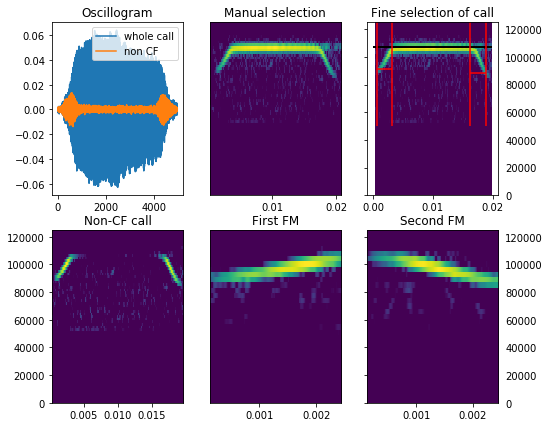

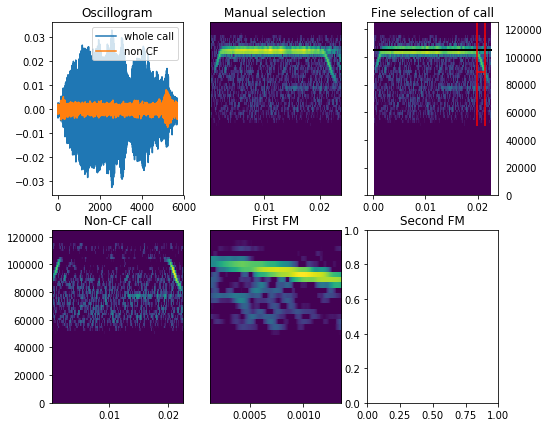

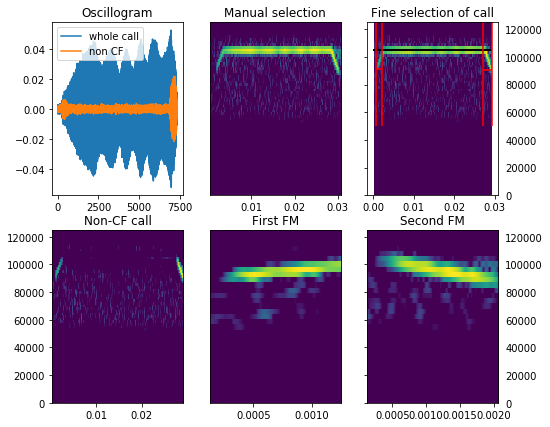

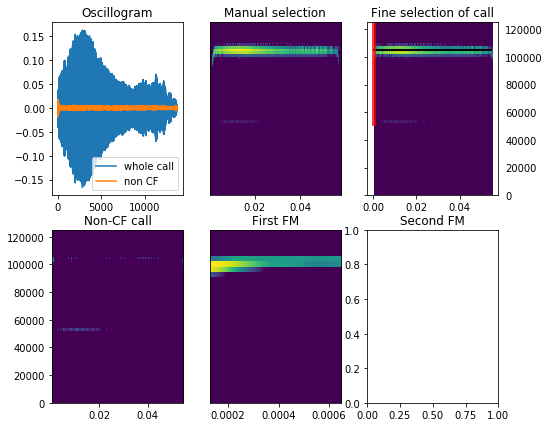

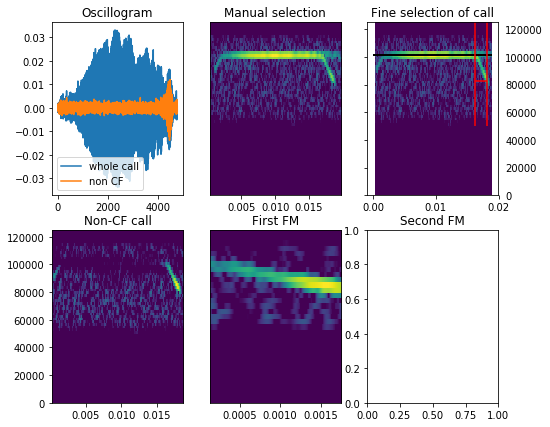

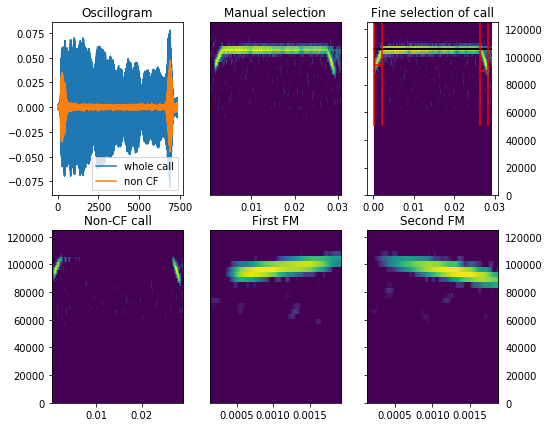

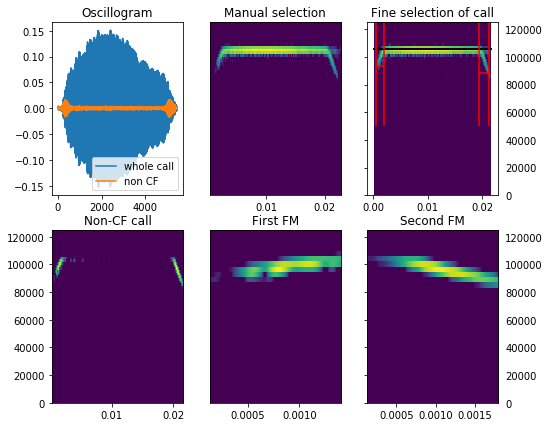

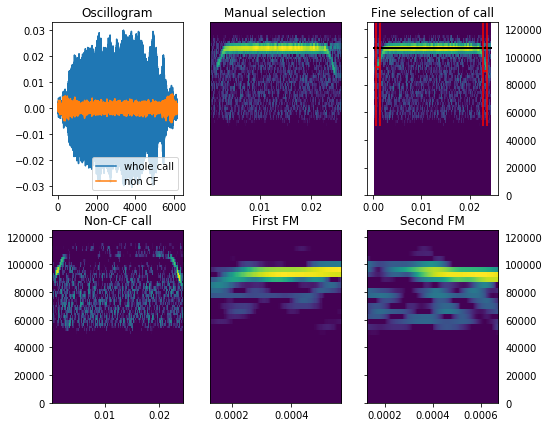

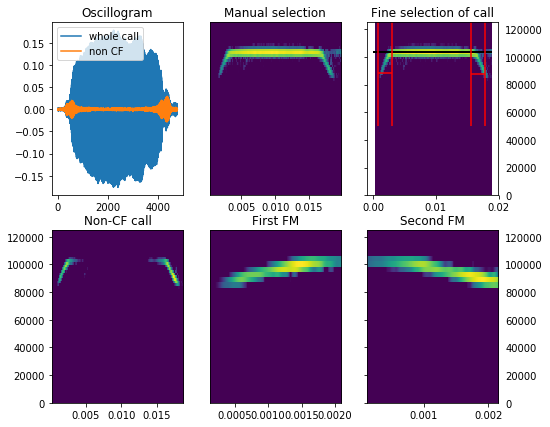

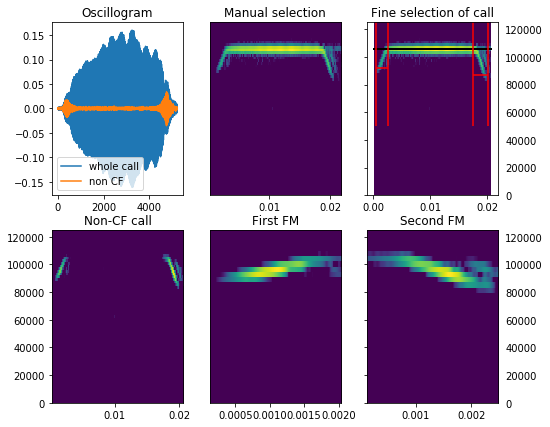

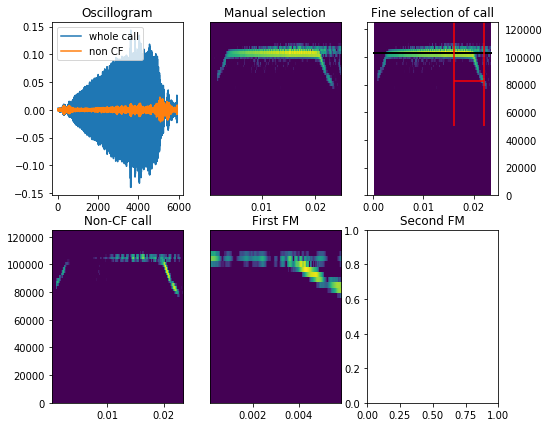

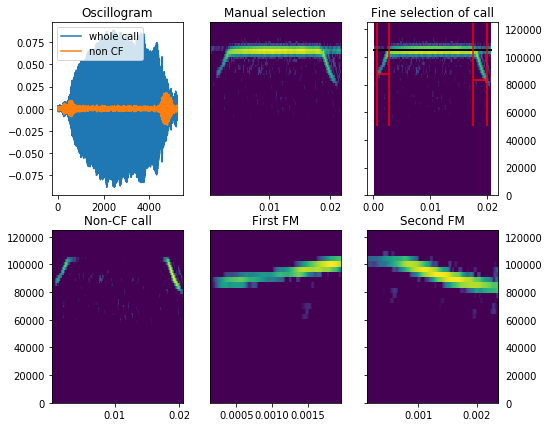

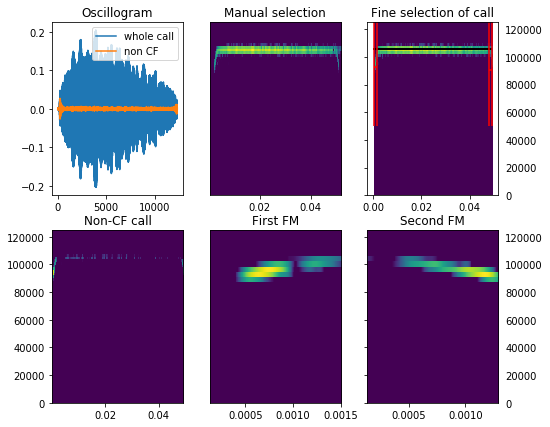

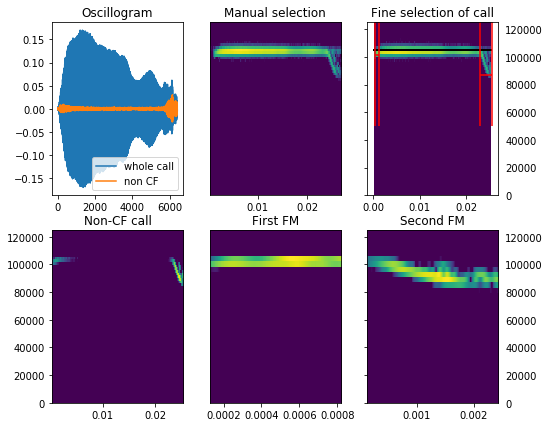

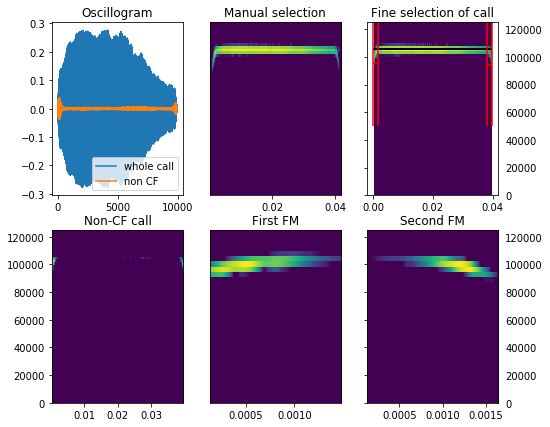

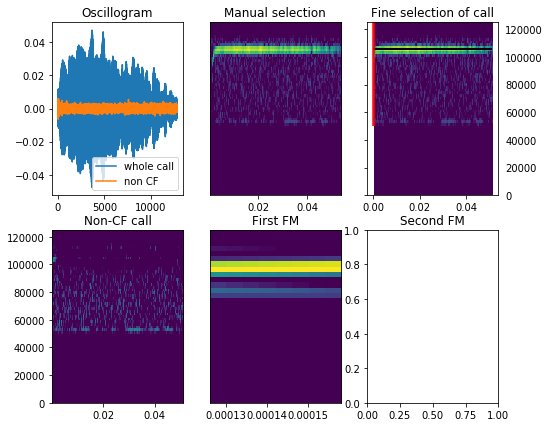

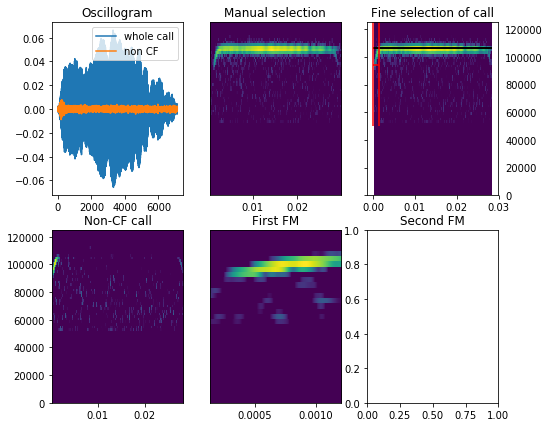

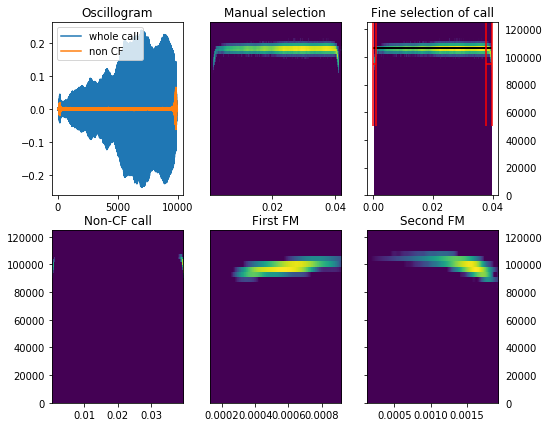

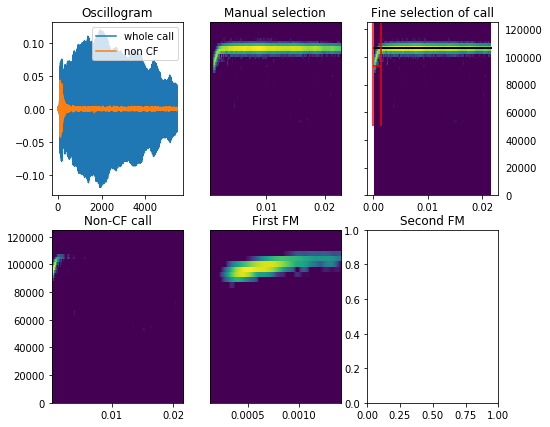

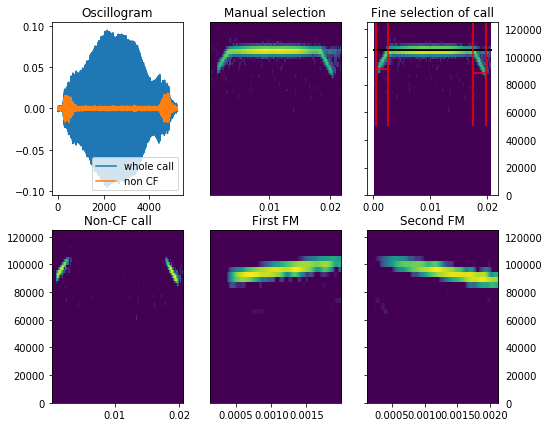

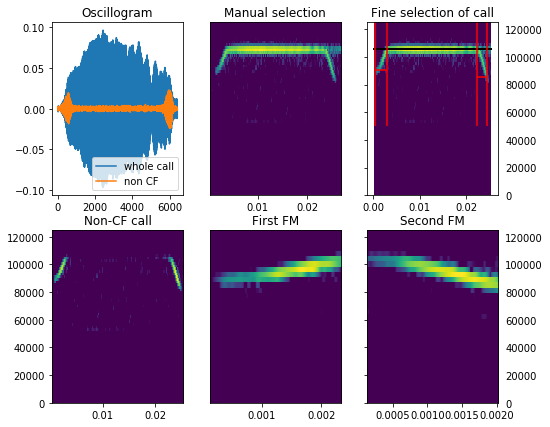

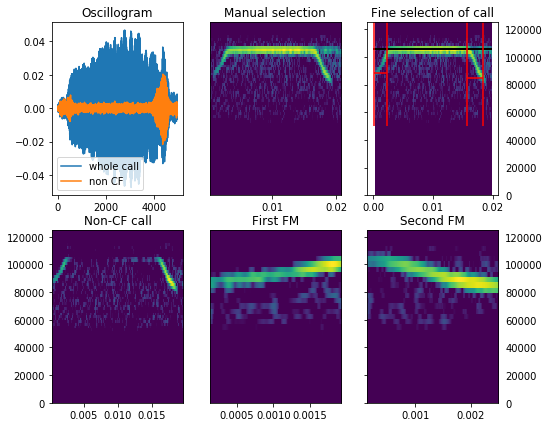

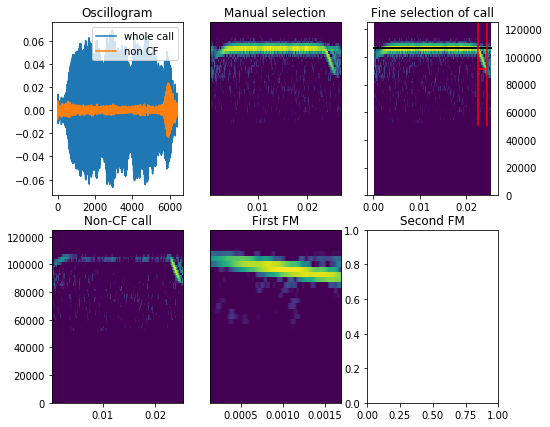

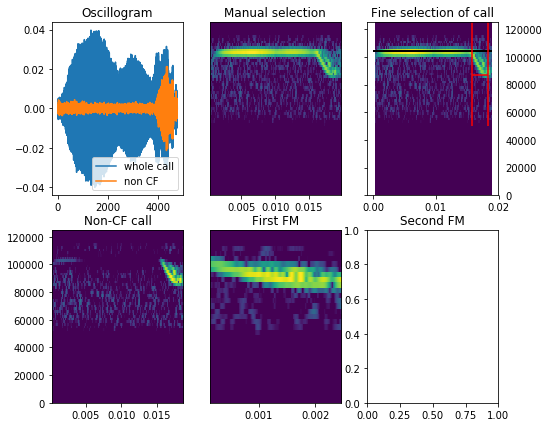

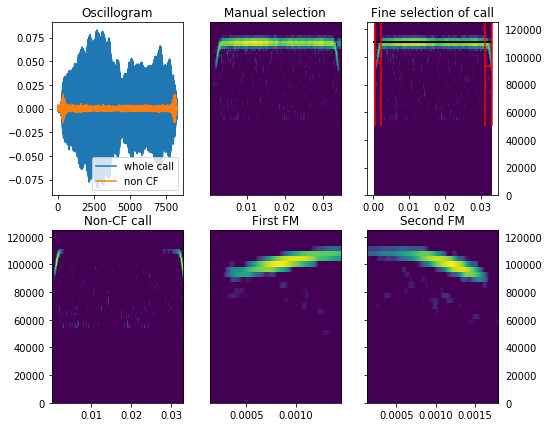

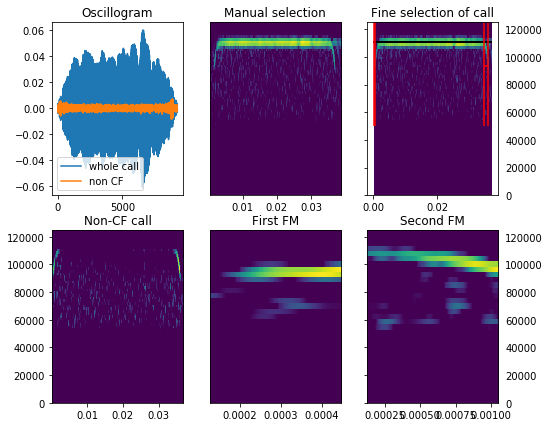

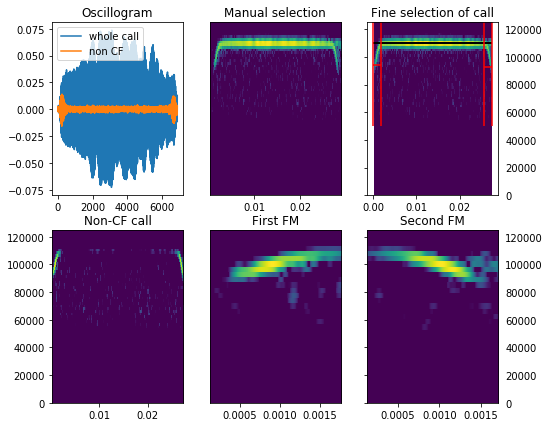

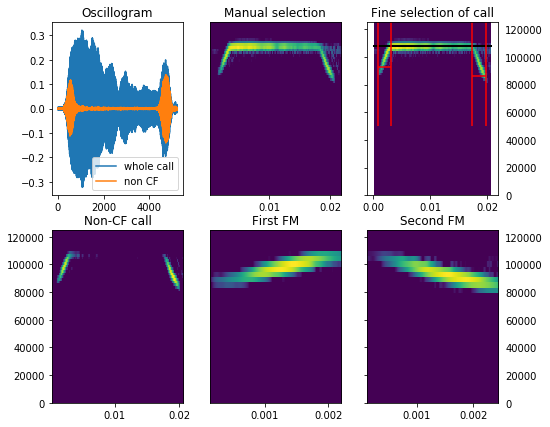

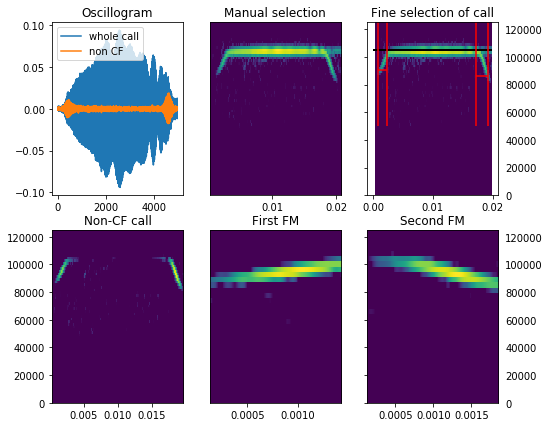

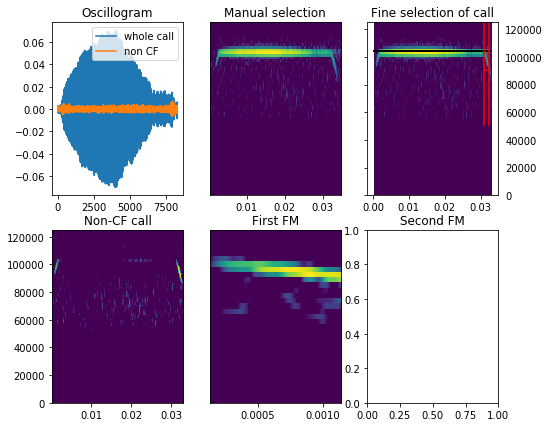

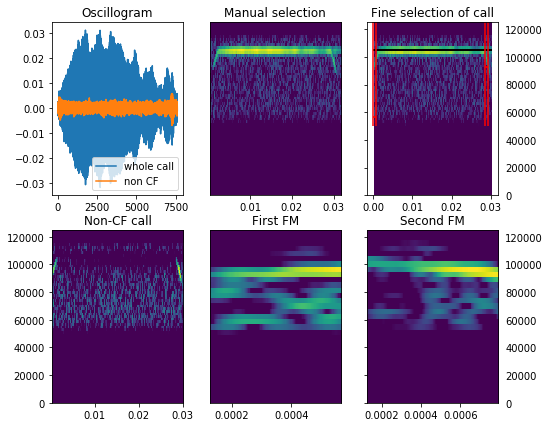

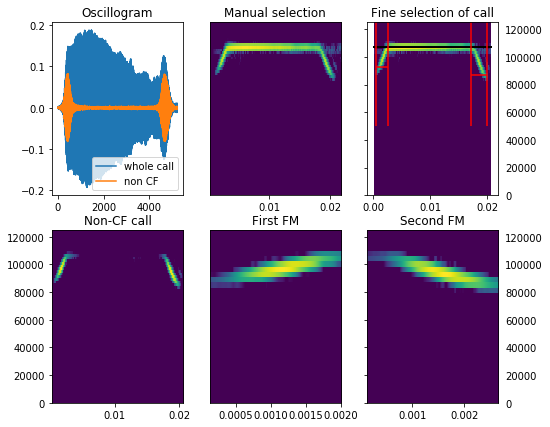

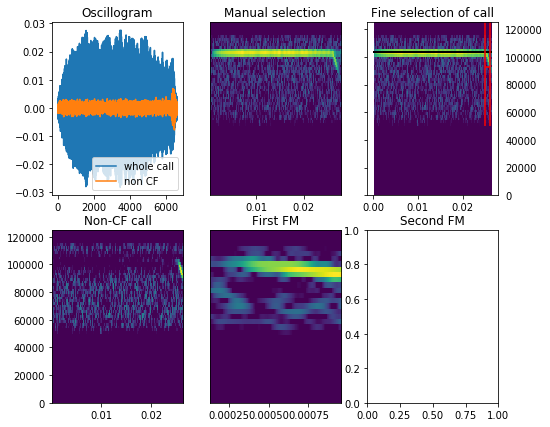

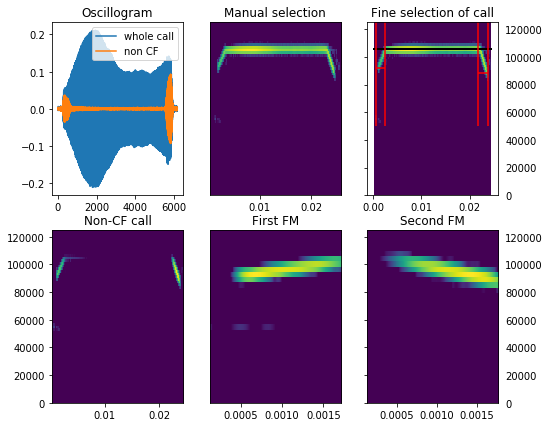

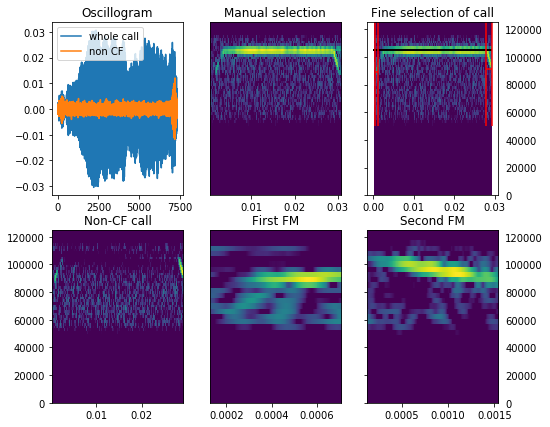

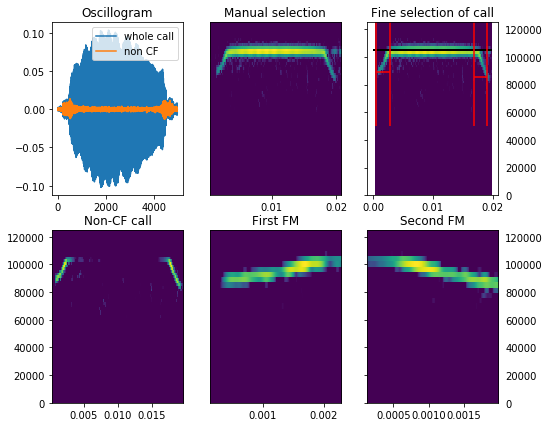

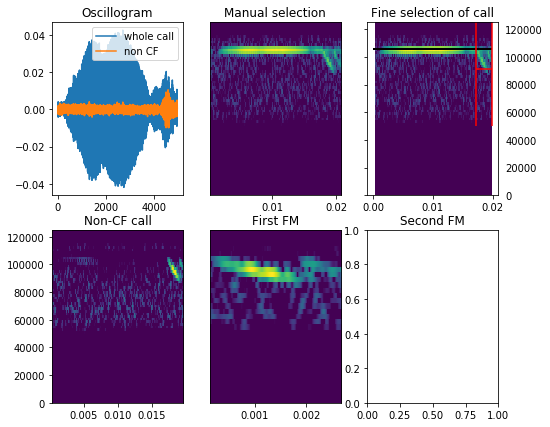

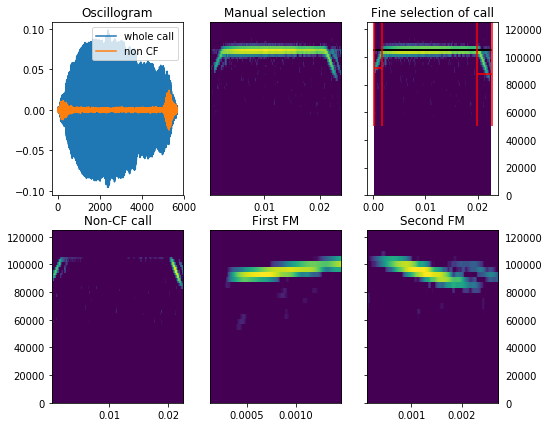

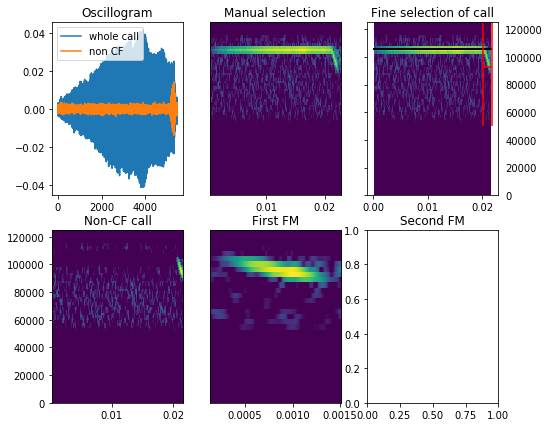

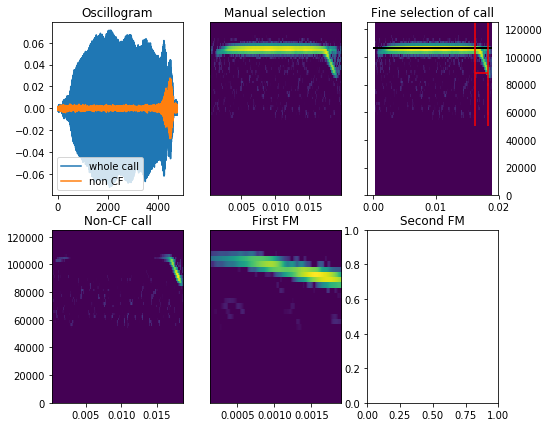

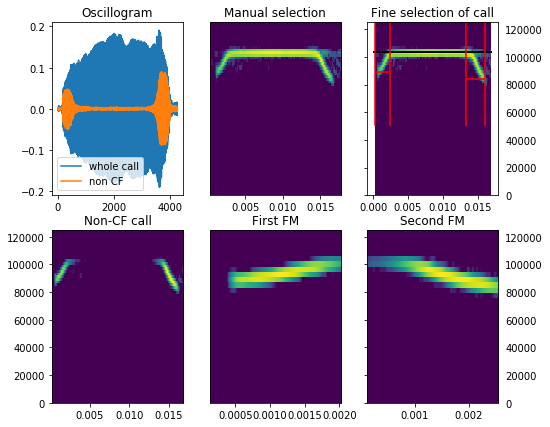

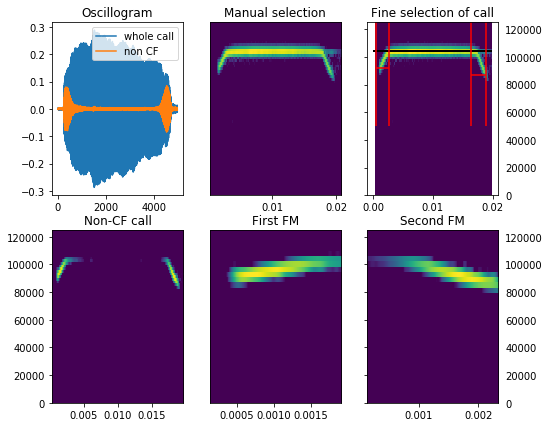

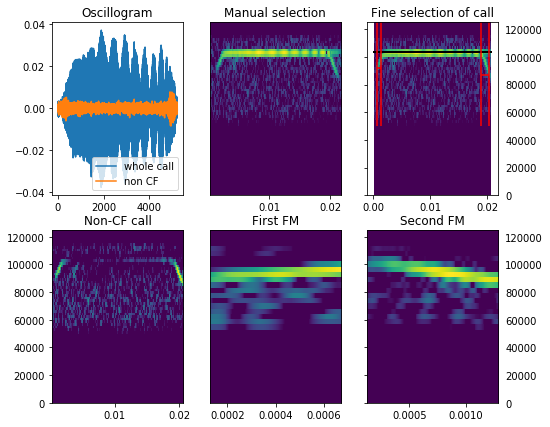

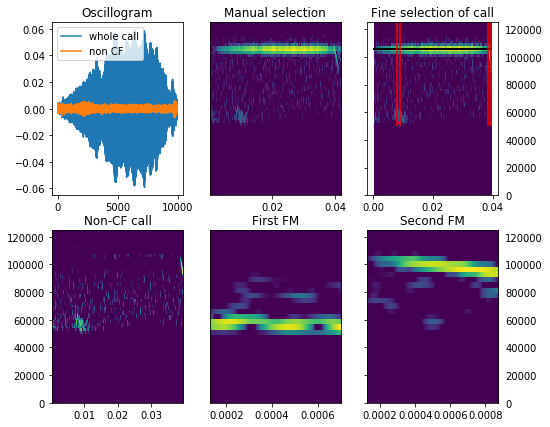

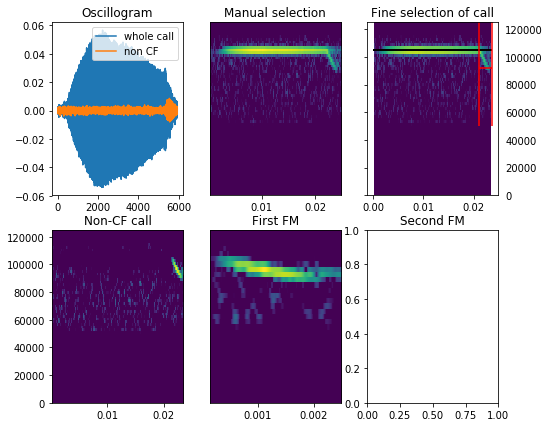

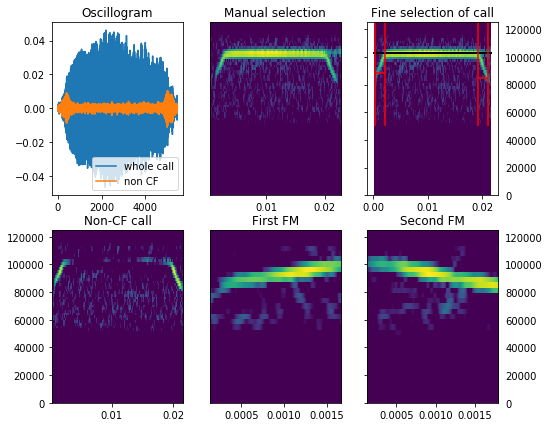

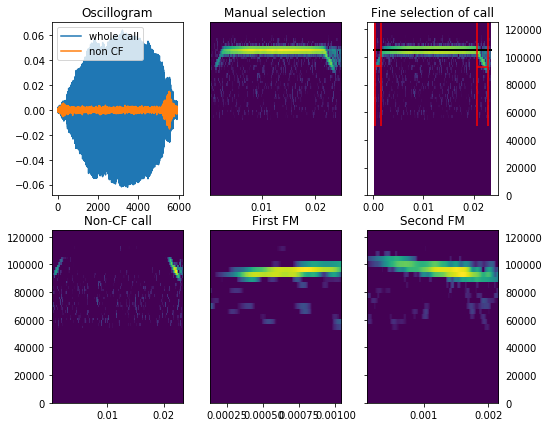

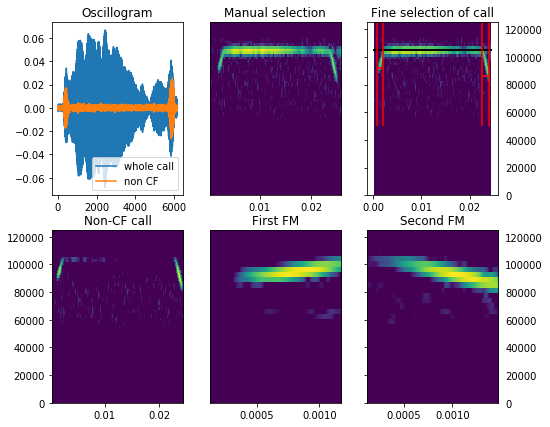

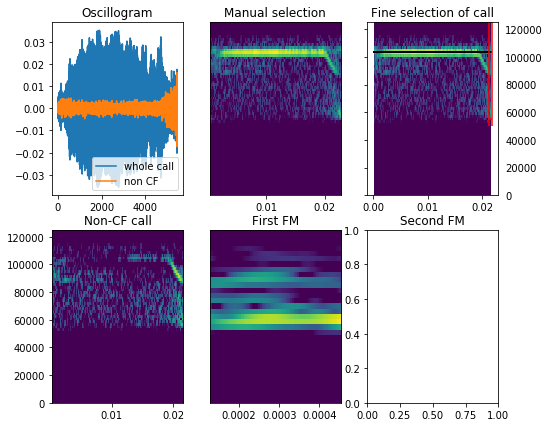

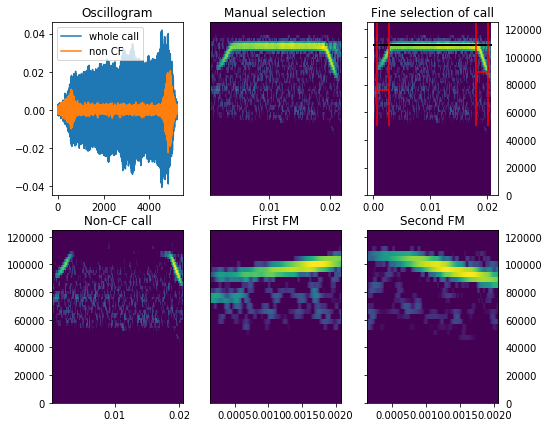

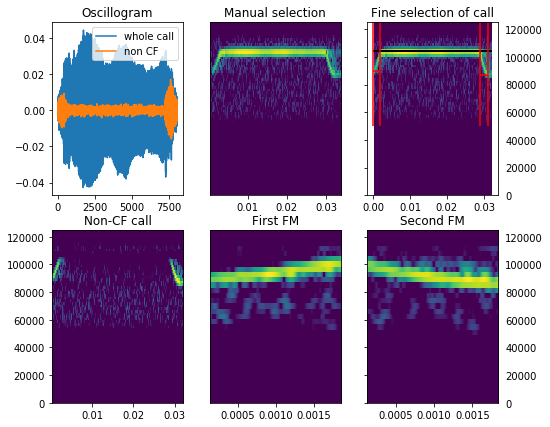

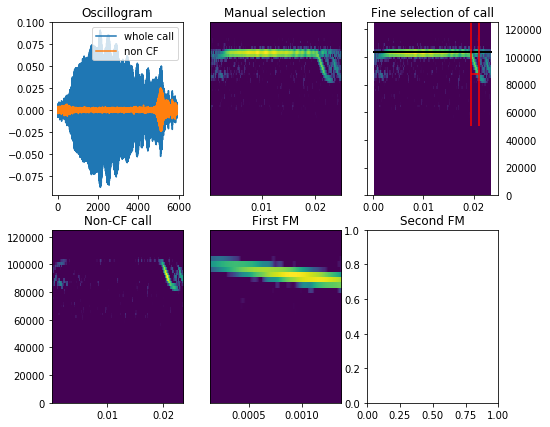

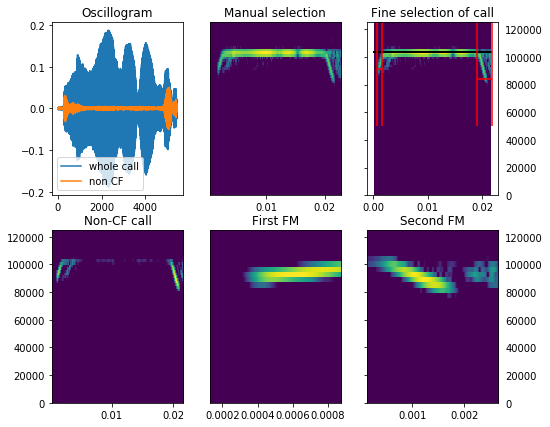

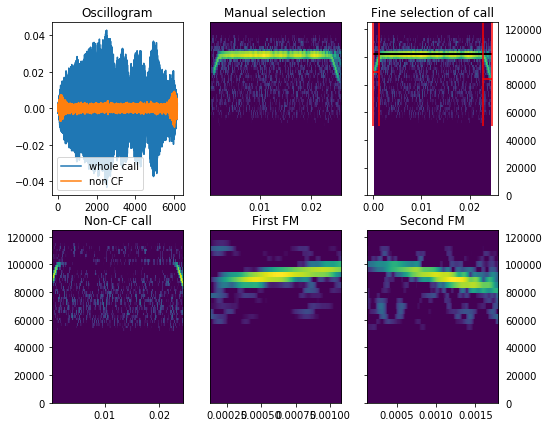

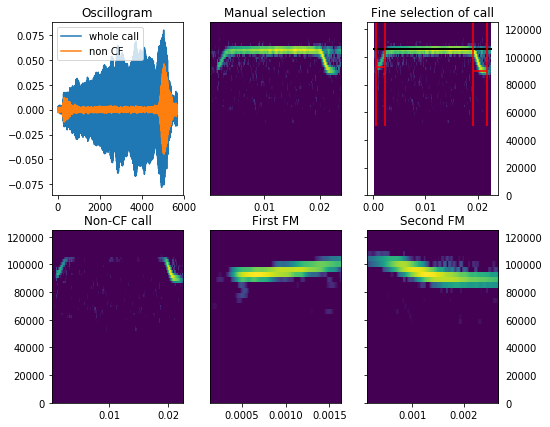

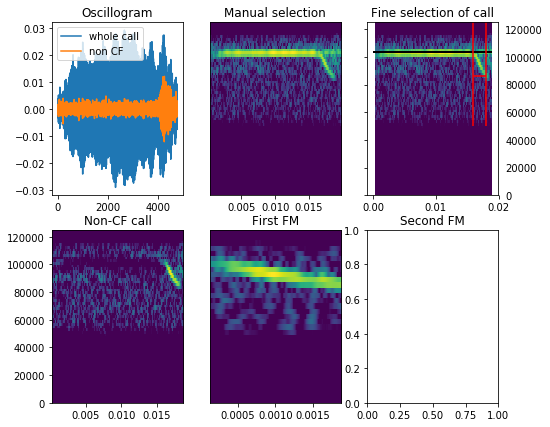

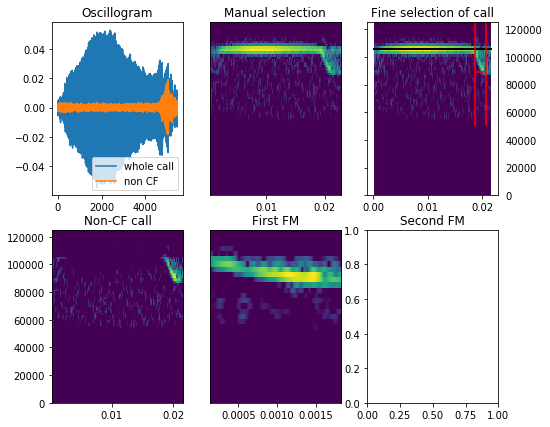

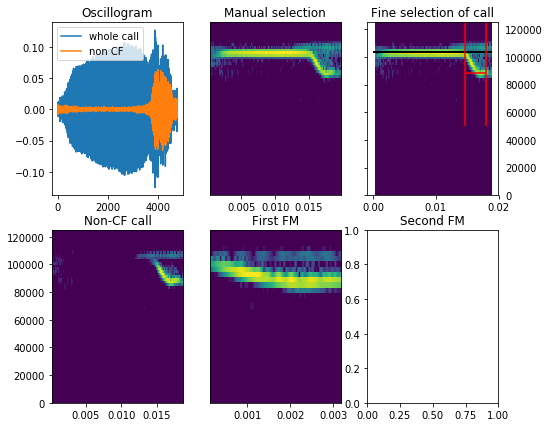

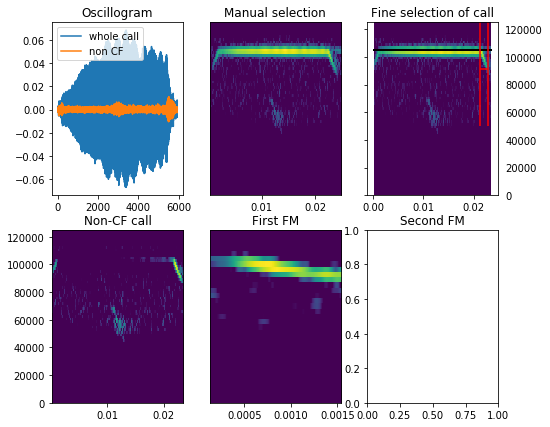

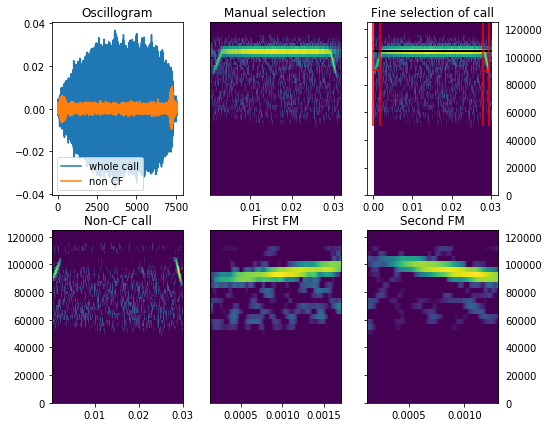

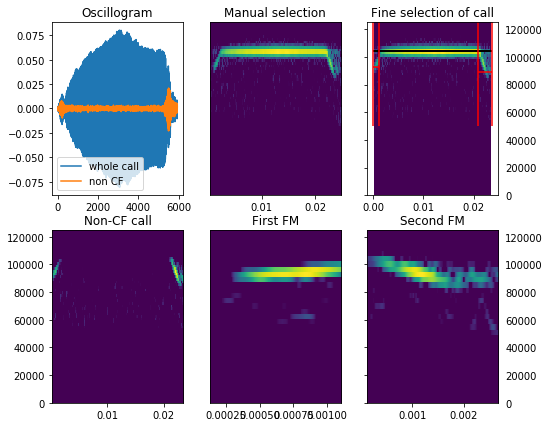

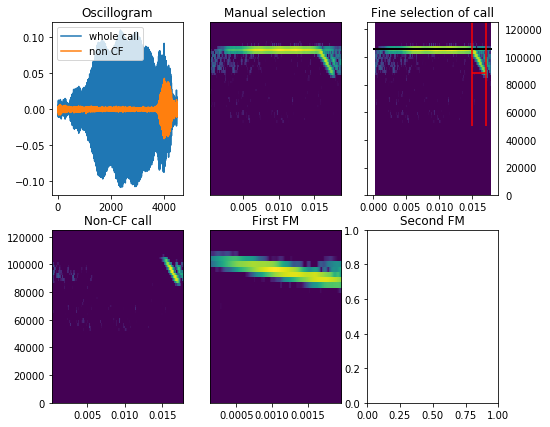

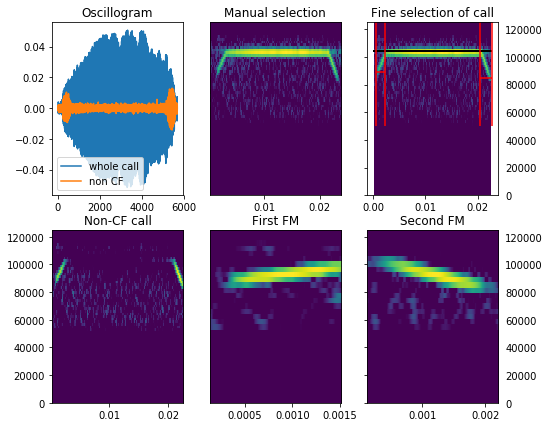

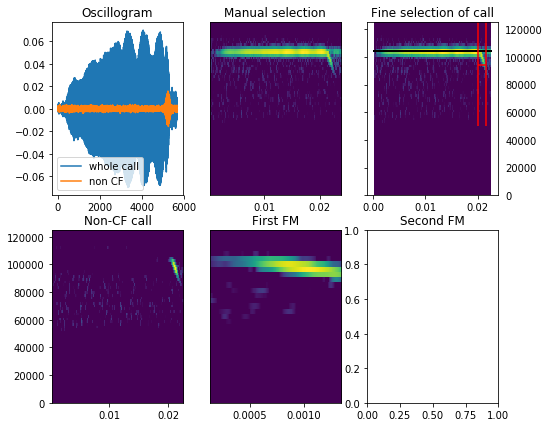

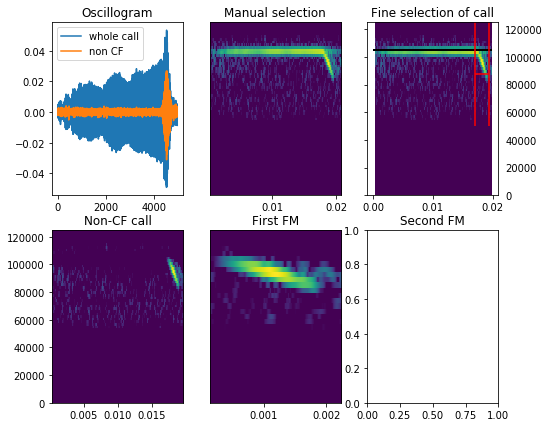

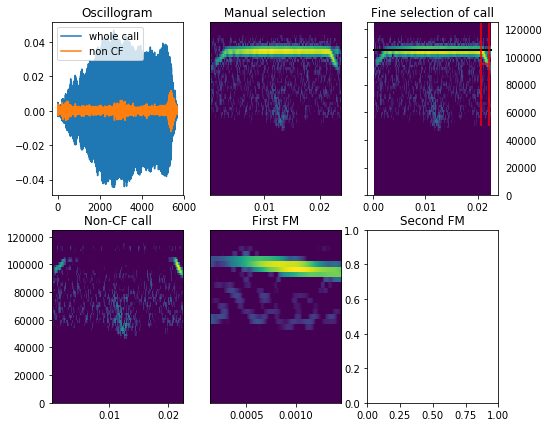

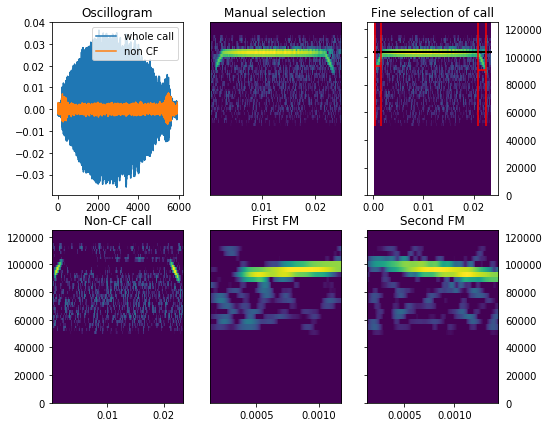

In [21]:
fs = 250000
b,a = signal.butter(8, np.array([55000.0, 115000])/(fs*0.5), 'bandpass')
#for i in range(single_calls.shape[0]):
#for i in range(with_geq_1_call.shape[0]):
for i in range(with_geq_1_call.shape[0]):
    each_row = with_geq_1_call.iloc[i,:]
    audio_file_name = each_row['audio_annotation_file']+'.WAV'
    audio, fs = sf.read(matched_audio_folder+audio_file_name)
    bp_audio = signal.lfilter(b,a,audio[:,0])

    print(each_row['audio_annotation_file'])
    gap = 250
    start_sample, end_sample = int(each_row['call_start_time']*fs)-gap, int(each_row['call_end_time']*fs)+gap
    one_call = bp_audio[start_sample:end_sample]
    try:
        sounds, msmts = measure_hbc_call(one_call, fs=fs, min_cf_duration=0.01,
                                         q_factor=5, min_fm_duration=0.001, dB_above_threshold=5,
                                         fm_max_durn=0.008, seg_length=4096, threshold=-10)
        make_overview_figure(one_call, sounds,  msmts,fftsize=128,fs=fs, dyn_range=80)
        plt.savefig(output_folder+'overview_'+each_row['audio_annotation_file']+'.WAV'+'.png')
        msmts['annotation_id'] = each_row['audio_annotation_file']+'.WAV'
        all_msmts.append(msmts)
        sf.write(all_matched_audio+'success_one_call/'+audio_file_name, one_call, fs)
    except:
        failed_msmts.append(audio_file_name)
        sf.write(all_matched_audio+'failed_one_call/'+audio_file_name, one_call, fs)
        pass



In [22]:
failed_msmts

['matching_annotaudio_Aditya_2018-08-17_34_2.WAV',
 'matching_annotaudio_Aditya_2018-08-17_34_81.WAV',
 'matching_annotaudio_Aditya_2018-08-17_23_137.WAV',
 'matching_annotaudio_Aditya_2018-08-17_23_172.WAV',
 'matching_annotaudio_Aditya_2018-08-17_56_9.WAV']

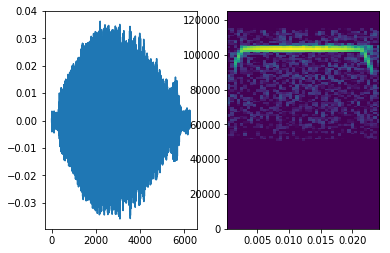

In [23]:
dyn = 20*np.log10(np.max(abs(one_call))) - 80
plt.figure()
plt.subplot(121)
plt.plot(one_call)

plt.subplot(122)
plt.specgram(one_call, Fs=fs, vmin=dyn);

#### measure_hbc_calls faces problems when:

> the Cf call has no FM,  and multiple spurious peaks show up in the non-CF audio are picked up

> the call is 'banded' with high and low parts, and these turn up as high-low parts post-filtering too. 

> calls that don't have an FM

> call window selection is too sharp - and the FM parts don't show up as having much energy post notch-filtering

In [24]:
msmts_df = pd.concat(all_msmts).reset_index(drop=True)

/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [25]:
msmts_df.head()

annotation_id  call_duration  \
0   matching_annotaudio_Aditya_2018-08-17_34_1.WAV       0.019944   
1   matching_annotaudio_Aditya_2018-08-17_34_7.WAV       0.022796   
2  matching_annotaudio_Aditya_2018-08-17_34_12.WAV       0.029444   
3  matching_annotaudio_Aditya_2018-08-17_34_18.WAV       0.055104   
4  matching_annotaudio_Aditya_2018-08-17_34_19.WAV       0.018992   

   call_energy  call_rms  cf_duration  cf_energy    cf_rms  downfm_end_time  \
0     4.709993  0.030735     0.014800   4.661473  0.035494         0.018856   
1     0.941861  0.012856     0.021320   0.929416  0.013205         0.021428   
2     3.845675  0.022857     0.025872   3.784992  0.024191         0.029440   
3    46.275893  0.057958     0.054332  46.231804  0.058341              NaN   
4     0.835755  0.013267     0.017116   0.819602  0.013840         0.018084   

   downfm_energy  downfm_rms  downfm_start_time  downfm_terminal_frequency  \
0       0.019684    0.005520           0.016272               88235.294118   
1       0.004076    0.003323           0.019952               88753.387534   
2       0.049927    0.009536           0.027244               90163.934426   
3            NaN         NaN                NaN                        NaN   
4       0.010410    0.004711           0.016208               82622.601279   

   peak_frequency  upfm_end_time  upfm_energy  upfm_rms  upfm_start_time  \
0   106811.523438       0.003148     0.022624  0.005946         0.000588   
1   104919.433594            NaN          NaN       NaN              NaN   
2   105224.609375       0.002100     0.002757  0.002831         0.000724   
3   105163.574219       0.000772     0.009392  0.006976         0.000000   
4   101501.464844            NaN          NaN       NaN              NaN   

   upfm_terminal_frequency  
0             91015.625000  
1                      NaN  
2             91569.767442  
3             95854.922280  
4                      NaN

In [26]:
msmts_df.shape

(67, 18)

### Manual selection of call measurements and segmentations:
The automated 'measure_CF_call' package does a pretty decent job, but it fails especially badly when CF calls have intereference, or the audio selection is very narrow. Here I will choose only those calls that have been segmented correctly - and thus whole measurements are reliable. 

### Other observations/ manual alterations to be done to msmts_df:
(notes made with dB_above_threshold at default +3 dB)

* Aditya_2018-08-17_23_14 : downfm segmented poorly. Remove measurement.
* Aditya_2018-08-17_23_141 : echo in call leads to weird FM segmentation. Remove measurement. 

* Aditya_2018-08-17_34_7 : upfm is not registered. Remove measurement. 
* Aditya_2018-08-17_34_18 : choppy CF. Remove measurement. 
* Aditya_2018-08-17_34_19 : Only CF is prominent, and upFM is not registered. Remove measurement. 
* Aditya_2018-08-17_34_22 : FM is not segmented correctly. Remove measurement. 
* Aditya_2018-08-17_34_39 : FM is chopped. Remove measurement. 
* Aditya_2018-08-17_34_41 :  FM is chopped. Remove measurement. 
* Aditya_2018-08-17_34_56 : annotation end is too short - needs to be re-checked.
* Aditya_2018-08-17_34_132 : No upFM detected. Remove measurement.
* Aditya_2018-08-17_34_133 : FM's not segmented properly. Remove measurement.
* Aditya_2018-08-17_34_145 : the upFM is cut in half. Remove measurement.
* Aditya_2018-08-17_34_149 : strong FM echo. Remove measurement.
* Aditya_2018-08-17_34_170 : chopped CF. Remove measurement. 
* Aditya_2018-08-17_34_171 : chopped CF. Remove measurement. 
* Aditya_2018-08-17_34_211 : chopped CF. Remove measurement. 

* Aditya_2018-08-17_56_6 : upFM not registered. Remove measurement. 
* Aditya_2018-08-17_56_109 : upFM not registered. Remove measurement. 




False upFMs: 
* Aditya_2018-08-17_34_43 : there is an upfm registered, which shouldn't be there. Set all upFM values to np.nan
* Aditya_2018-08-17_34_52 : there is an upfm registered, which shouldn't be there. Set all upFM values to np.nan
* Aditya_2018-08-17_34_71 : there is an upfm registered, which shouldn't be there. Set all upFM values to np.nan



In [27]:
def get_row_indices_of_annotation_ids(annotation_ids, df):
    '''
    '''
    all_indices = []
    for each in annotation_ids:
        index = df[df['annotation_id']==each].index
        all_indices.append(index)
    return np.concatenate(all_indices)
        

In [28]:
# measurements to be removed : 
to_remove = ['17_23_14','17_23_141', '17_34_7', '17_34_18', '17_34_19', '17_34_22', '17_34_39','17_34_41','17_34_56','17_34_132','17_34_133',
            '17_34_145', '17_34_149', '17_34_170', '17_34_171', '17_34_211', '17_56_6', '17_56_109']
to_remove = [ 'matching_annotaudio_Aditya_2018-08-'+each+'.WAV' for each in to_remove]
len(to_remove)
all_indices = get_row_indices_of_annotation_ids(to_remove, msmts_df)


In [29]:
msmts_df.head()

annotation_id  call_duration  \
0   matching_annotaudio_Aditya_2018-08-17_34_1.WAV       0.019944   
1   matching_annotaudio_Aditya_2018-08-17_34_7.WAV       0.022796   
2  matching_annotaudio_Aditya_2018-08-17_34_12.WAV       0.029444   
3  matching_annotaudio_Aditya_2018-08-17_34_18.WAV       0.055104   
4  matching_annotaudio_Aditya_2018-08-17_34_19.WAV       0.018992   

   call_energy  call_rms  cf_duration  cf_energy    cf_rms  downfm_end_time  \
0     4.709993  0.030735     0.014800   4.661473  0.035494         0.018856   
1     0.941861  0.012856     0.021320   0.929416  0.013205         0.021428   
2     3.845675  0.022857     0.025872   3.784992  0.024191         0.029440   
3    46.275893  0.057958     0.054332  46.231804  0.058341              NaN   
4     0.835755  0.013267     0.017116   0.819602  0.013840         0.018084   

   downfm_energy  downfm_rms  downfm_start_time  downfm_terminal_frequency  \
0       0.019684    0.005520           0.016272               88235.294118   
1       0.004076    0.003323           0.019952               88753.387534   
2       0.049927    0.009536           0.027244               90163.934426   
3            NaN         NaN                NaN                        NaN   
4       0.010410    0.004711           0.016208               82622.601279   

   peak_frequency  upfm_end_time  upfm_energy  upfm_rms  upfm_start_time  \
0   106811.523438       0.003148     0.022624  0.005946         0.000588   
1   104919.433594            NaN          NaN       NaN              NaN   
2   105224.609375       0.002100     0.002757  0.002831         0.000724   
3   105163.574219       0.000772     0.009392  0.006976         0.000000   
4   101501.464844            NaN          NaN       NaN              NaN   

   upfm_terminal_frequency  
0             91015.625000  
1                      NaN  
2             91569.767442  
3             95854.922280  
4                      NaN

In [30]:
all_indices

array([48, 52,  1,  3,  4,  6, 10, 12, 18, 29, 30, 34, 36, 42, 43, 47, 58,
       65])

In [31]:
msmts_df.drop(all_indices, inplace=True)

In [32]:
msmts_df.shape

(49, 18)

In [33]:
# measurements where upFM should be set to np.nan
upfm_to_nan = ['17_34_43', '17_34_52', '17_34_71']
upfm_to_nan = [ 'matching_annotaudio_Aditya_2018-08-'+each+'.WAV' for each in upfm_to_nan]
upfm_to_nan_indices = get_row_indices_of_annotation_ids(upfm_to_nan, msmts_df)

In [34]:
upfm_to_nan_indices

array([13, 15, 22])

In [35]:
msmts_df.iloc[upfm_to_nan_indices[0],:]

annotation_id                matching_annotaudio_Aditya_2018-08-17_34_65.WAV
call_duration                                                       0.025648
call_energy                                                          11.8318
call_rms                                                           0.0429565
cf_duration                                                          0.02104
cf_energy                                                            11.7313
cf_rms                                                             0.0472259
downfm_end_time                                                     0.024592
downfm_energy                                                      0.0574013
downfm_rms                                                         0.0103293
downfm_start_time                                                    0.02244
downfm_terminal_frequency                                            85501.9
peak_frequency                                                        105835

In [36]:
# set all the upFM columns to np.nan
all_columns = msmts_df.columns
upfm_columns = np.argwhere(['upfm' in each for each in all_columns]).flatten()
for each_faultyfm in upfm_to_nan_indices:
    msmts_df.iloc[each_faultyfm, upfm_columns] = np.nan

In [37]:
msmts_df.iloc[upfm_to_nan_indices[0],:]

annotation_id                matching_annotaudio_Aditya_2018-08-17_34_65.WAV
call_duration                                                       0.025648
call_energy                                                          11.8318
call_rms                                                           0.0429565
cf_duration                                                          0.02104
cf_energy                                                            11.7313
cf_rms                                                             0.0472259
downfm_end_time                                                     0.024592
downfm_energy                                                      0.0574013
downfm_rms                                                         0.0103293
downfm_start_time                                                    0.02244
downfm_terminal_frequency                                            85501.9
peak_frequency                                                        105835

### How many unique peak frequencies are there?
In the RAVEN based analyses that Neetash had run, we had seen this puzzling observation where the peak frequencies were not spread uniformly between 100-110 kHz, but rather that they were at discrete frequencies, and the same frequencies popped up repeatedly over a period of time. This was a bit unusual, and we weren't quite sure why it was so. Now I'm also seeing a similar pattern from the video-matched audio, and so can be *sure* that this is the result of the biology itself. 

Initally, I too recovered tis kind of weird pattern with ~10 repeated frequencies. N & I later realised that the reason there were just 10 repeated frequencies is because the window size wsa set to 256 samples -- which emans the frequency resolution of the peak frequency measurements were rather poor - and thus the repeats. Neetash also had a similar setting in RAVEN, with a 512 sample FFT size - and thus saw ~30 repeated unique peak frequencies.  

We played around with the FFT size for frequency measurements and of course saw that longer FFT sizes led to better frequency resolution -- and *lower* number of repeated frequencies. 

However, there is tradeoff - longer window sizes can mean that the 'robust' peak detection Holger suggested won't work as well for short duration calls. Thus, it's best to choose the smallest window size that is a bit smaller than the shortest duration calls. We here choose 2048samples FFT size, which corresponds to ~8ms.

In [38]:
unique_PFs, count_PFs = np.unique(msmts_df['peak_frequency'], return_counts=True)
# numer of unique frequencies
print(len(unique_PFs))
# the unique peak frequencies and their occurence:
print(unique_PFs)
print(count_PFs, sum(count_PFs))

35
[101928.7109375  102844.23828125 103210.44921875 103332.51953125
 103393.5546875  103454.58984375 103637.6953125  103881.8359375
 103942.87109375 104125.9765625  104248.046875   104431.15234375
 104553.22265625 104614.2578125  104736.328125   104797.36328125
 104919.43359375 105041.50390625 105163.57421875 105224.609375
 105407.71484375 105529.78515625 105590.8203125  105712.890625
 105834.9609375  106018.06640625 106079.1015625  106323.2421875
 106628.41796875 106811.5234375  107421.875      108032.2265625
 108520.5078125  110351.5625     110900.87890625]
(array([1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 3,
       1, 1, 3, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2]), 49)


### How much Doppler shift *is* expected?


In [39]:
v_bat = 5.0 # m/s
v_sound = 330.0

def calc_doppler_shift(v_bat, f_0, v_sound=330.0):
    doppler_shift = f_0 - f_0*(v_sound/(v_bat+v_sound))
    return doppler_shift   


In [40]:
v_bat = np.linspace(2.5, 8.0, 10)
f0 = 100*10**3
doppler_shift_w_velocity = [calc_doppler_shift(each,f0) for each in v_bat]

Text(0,0.5,'Doppler shift, Hz')

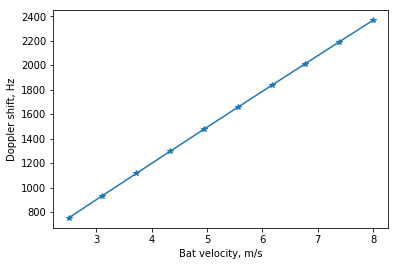

In [41]:
plt.figure()
plt.plot(v_bat, doppler_shift_w_velocity,'-*')
plt.xlabel('Bat velocity, m/s');
plt.ylabel('Doppler shift, Hz')

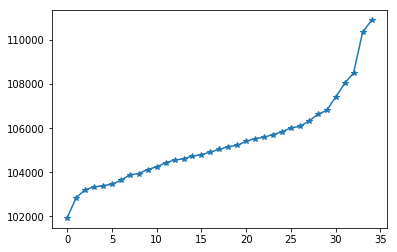

In [42]:
plt.figure()
plt.plot(unique_PFs,'-*')

In [43]:
def get_annotation_number(annotation_id):
    split_parts = annotation_id.split('_')
    id_number = split_parts[-1]
    return id_number

In [44]:
msmts_df['annotation_number'] = [get_annotation_number(each_row['annotation_id'].split('.')[0]) for i,each_row in msmts_df.iterrows()]

In [45]:
msmts_df.head()

annotation_id  call_duration  \
0   matching_annotaudio_Aditya_2018-08-17_34_1.WAV       0.019944   
2  matching_annotaudio_Aditya_2018-08-17_34_12.WAV       0.029444   
5  matching_annotaudio_Aditya_2018-08-17_34_20.WAV       0.029448   
7  matching_annotaudio_Aditya_2018-08-17_34_32.WAV       0.024700   
8  matching_annotaudio_Aditya_2018-08-17_34_35.WAV       0.018996   

   call_energy  call_rms  cf_duration  cf_energy    cf_rms  downfm_end_time  \
0     4.709993  0.030735     0.014800   4.661473  0.035494         0.018856   
2     3.845675  0.022857     0.025872   3.784992  0.024191         0.029440   
5     7.456509  0.031825     0.025380   7.163594  0.033601         0.028340   
7     1.177102  0.013807     0.023208   1.167025  0.014182         0.023648   
8    37.504727  0.088867     0.014504  37.368566  0.101517         0.017800   

   downfm_energy  downfm_rms  downfm_start_time  downfm_terminal_frequency  \
0       0.019684    0.005520           0.016272               88235.294118   
2       0.049927    0.009536           0.027244               90163.934426   
5       0.165268    0.018126           0.026328               89960.238569   
7       0.001146    0.002394           0.022848               90000.000000   
8       0.087221    0.012370           0.015520               87719.298246   

   peak_frequency  upfm_end_time  upfm_energy  upfm_rms  upfm_start_time  \
0   106811.523438       0.003148     0.022624  0.005946         0.000588   
2   105224.609375       0.002100     0.002757  0.002831         0.000724   
5   105712.890625       0.002252     0.117989  0.015151         0.000196   
7   106628.417969       0.001404     0.000768  0.002107         0.000712   
8   103881.835938       0.003032     0.036693  0.008146         0.000820   

   upfm_terminal_frequency annotation_number  
0             91015.625000                 1  
2             91569.767442                12  
5             94357.976654                20  
7             92485.549133                32  
8             88607.594937                35

In [46]:
msmts_df.iloc[41,:]

annotation_id                matching_annotaudio_Aditya_2018-08-17_23_70.WAV
call_duration                                                       0.018996
call_energy                                                          13.6586
call_rms                                                           0.0536293
cf_duration                                                           0.0157
cf_energy                                                            12.8645
cf_rms                                                             0.0572502
downfm_end_time                                                     0.017956
downfm_energy                                                       0.747045
downfm_rms                                                         0.0301099
downfm_start_time                                                    0.01466
downfm_terminal_frequency                                            87985.4
peak_frequency                                                        103210

In [47]:
all_video_annotations['annotation_number'] = [get_annotation_number(each_row['annotation_id']) for i,each_row in all_video_annotations.iterrows()]

In [48]:
# get number of bats from each annotation id
num_bats = []
for i, each_row in msmts_df.iterrows():
    part_annotation_id = each_row['annotation_id'][20:-4]
    video_annot_row = np.argwhere(all_video_annotations['annotation_id']==part_annotation_id)
    n_bats = all_video_annotations.loc[int(video_annot_row),'no. of flying bats']
    num_bats.append(n_bats)
msmts_df['number_of_bats'] = num_bats

/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


### How many cases of single, double and $\geq$2 bats?

In [49]:
np.unique(msmts_df['number_of_bats'], return_counts=True)

(array([1, 2, 3, 4]), array([28, 15,  3,  3]))

### Calculating derived measures (dB rms, dB energy,etc).

In [50]:
msmts_df.columns

Index([u'annotation_id', u'call_duration', u'call_energy', u'call_rms',
       u'cf_duration', u'cf_energy', u'cf_rms', u'downfm_end_time',
       u'downfm_energy', u'downfm_rms', u'downfm_start_time',
       u'downfm_terminal_frequency', u'peak_frequency', u'upfm_end_time',
       u'upfm_energy', u'upfm_rms', u'upfm_start_time',
       u'upfm_terminal_frequency', u'annotation_number', u'number_of_bats'],
      dtype='object')

In [51]:

msmts_df['cf_dB_rms'] = dB(msmts_df['cf_rms'])
msmts_df['upfm_dB_ms'] = dB(msmts_df['upfm_rms'])
msmts_df['downfm_dB_ms'] = dB(msmts_df['downfm_rms'])

msmts_df['call_dB_energy'] = dB(msmts_df['call_energy'])
msmts_df['cf_dB_energy'] = dB(msmts_df['cf_energy'])
msmts_df['downfm_dB_energy'] = dB(msmts_df['downfm_energy'])
msmts_df['upfm_dB_energy'] = dB(msmts_df['upfm_energy'])


In [52]:
%matplotlib notebook

In [53]:
plt.figure()
plt.plot(msmts_df['number_of_bats'], msmts_df['peak_frequency'],'*')
plt.xticks([1,2,3])

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x7f2ed6934dd0>,
 <a list of 3 Text xticklabel objects>)

In [54]:
plt.figure()
plt.plot(msmts_df['number_of_bats'], msmts_df['call_duration'],'*')
plt.xticks([1,2,3])

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x7f2ed6887550>,
 <a list of 3 Text xticklabel objects>)

In [55]:
plt.figure()
plt.plot(msmts_df['number_of_bats'], msmts_df['call_energy'],'*')
plt.xticks([1,2,3])

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x7f2ed684d910>,
 <a list of 3 Text xticklabel objects>)

In [56]:
plt.figure()
plt.boxplot(msmts_df['call_duration'])

<IPython.core.display.Javascript object>

{'boxes': [<matplotlib.lines.Line2D at 0x7f2ed691c290>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2ed67bdd50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2ed67c98d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2ed67c9510>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f2ed67bd5d0>,
  <matplotlib.lines.Line2D at 0x7f2ed67bd990>]}

In [57]:
msmts_df.columns

Index([u'annotation_id', u'call_duration', u'call_energy', u'call_rms',
       u'cf_duration', u'cf_energy', u'cf_rms', u'downfm_end_time',
       u'downfm_energy', u'downfm_rms', u'downfm_start_time',
       u'downfm_terminal_frequency', u'peak_frequency', u'upfm_end_time',
       u'upfm_energy', u'upfm_rms', u'upfm_start_time',
       u'upfm_terminal_frequency', u'annotation_number', u'number_of_bats',
       u'cf_dB_rms', u'upfm_dB_ms', u'downfm_dB_ms', u'call_dB_energy',
       u'cf_dB_energy', u'downfm_dB_energy', u'upfm_dB_energy'],
      dtype='object')

In [58]:
msmts_df['upfm_duration'] = msmts_df['upfm_end_time'] - msmts_df['upfm_start_time']
msmts_df['downfm_duration'] = msmts_df['downfm_end_time'] - msmts_df['downfm_start_time']


In [59]:
# split the measurements by the number of bats in the annotation:
msmts_by_group_size = msmts_df.groupby('number_of_bats')

In [60]:
plt.figure()
plt.boxplot([msmts_by_group_size.get_group(group_size)['peak_frequency'] for group_size in [1,2]]);
plt.ylabel('Peak CF frequency')
plt.xlabel('Group size')

<IPython.core.display.Javascript object>

Text(0.5,0,'Group size')

In [61]:
plt.figure()
plt.subplot(121)
plt.plot(msmts_df['number_of_bats'],  20*np.log10(msmts_df['downfm_rms']),'*')
plt.ylabel('dB CF/up FM')
plt.xticks([1,2])
plt.subplot(122)
plt.plot(msmts_df['number_of_bats'],  20*np.log10(msmts_df['upfm_rms']),'*')
plt.xticks([1,2])
plt.ylabel('dB CF/down FM')

<IPython.core.display.Javascript object>

Text(0,0.5,'dB CF/down FM')

In [62]:
plt.figure(figsize=(8,4))
plt.subplot(121)
sns.boxplot(x='number_of_bats',y='downfm_terminal_frequency',data=msmts_df, showfliers=False);

sns.swarmplot(x='number_of_bats',y='downfm_terminal_frequency',data=msmts_df, color="0.5");
plt.ylabel('Call duration')
plt.xlabel('Group size')
plt.ylim(70000,110000)
plt.ylabel('End down-FM frequency (-10 dB threshold)')
plt.grid()
a0=plt.subplot(122)
sns.boxplot(x='number_of_bats',y='upfm_terminal_frequency',data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y='upfm_terminal_frequency',data=msmts_df, color="0.5");
plt.ylabel('Call duration')
plt.xlabel('Group size')
a0.yaxis.tick_right()
plt.ylabel('End up-FM frequency (-10 dB threshold)')
plt.ylim(70000,110000)
plt.grid()

<IPython.core.display.Javascript object>

In [63]:
dB = lambda X: 20*np.log10(abs(X))

In [64]:
msmts_df.columns

Index([u'annotation_id', u'call_duration', u'call_energy', u'call_rms',
       u'cf_duration', u'cf_energy', u'cf_rms', u'downfm_end_time',
       u'downfm_energy', u'downfm_rms', u'downfm_start_time',
       u'downfm_terminal_frequency', u'peak_frequency', u'upfm_end_time',
       u'upfm_energy', u'upfm_rms', u'upfm_start_time',
       u'upfm_terminal_frequency', u'annotation_number', u'number_of_bats',
       u'cf_dB_rms', u'upfm_dB_ms', u'downfm_dB_ms', u'call_dB_energy',
       u'cf_dB_energy', u'downfm_dB_energy', u'upfm_dB_energy',
       u'upfm_duration', u'downfm_duration'],
      dtype='object')

In [65]:
plt.figure()
plt.boxplot([dB(msmts_by_group_size.get_group(group_size)['cf_energy']/msmts_by_group_size.get_group(group_size)['call_duration']) for group_size in [1,2]]);
plt.ylabel('dB CF energy/call_duration')
plt.xlabel('Group size')

<IPython.core.display.Javascript object>

Text(0.5,0,'Group size')

In [66]:
plt.figure()
plt.subplot(121)
sns.boxplot(x='number_of_bats',y='call_duration',data=msmts_df, showfliers=False);

sns.swarmplot(x='number_of_bats',y='call_duration',data=msmts_df, color="0.5");
plt.ylabel('Call duration')
plt.xlabel('Group size')
plt.ylim(0.01,0.07)
a1 = plt.subplot(122)
sns.boxplot(x='number_of_bats',y='cf_duration',data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y='cf_duration',data=msmts_df, color="0.5");
plt.ylabel('CF duration')
plt.xlabel('Group size')
a1.yaxis.tick_right()
plt.ylim(0.01,0.07)


<IPython.core.display.Javascript object>

(0.01, 0.07)

In [67]:
sorted(msmts_df.columns)

['annotation_id',
 'annotation_number',
 'call_dB_energy',
 'call_duration',
 'call_energy',
 'call_rms',
 'cf_dB_energy',
 'cf_dB_rms',
 'cf_duration',
 'cf_energy',
 'cf_rms',
 'downfm_dB_energy',
 'downfm_dB_ms',
 'downfm_duration',
 'downfm_end_time',
 'downfm_energy',
 'downfm_rms',
 'downfm_start_time',
 'downfm_terminal_frequency',
 'number_of_bats',
 'peak_frequency',
 'upfm_dB_energy',
 'upfm_dB_ms',
 'upfm_duration',
 'upfm_end_time',
 'upfm_energy',
 'upfm_rms',
 'upfm_start_time',
 'upfm_terminal_frequency']

In [68]:
variable = 'cf_dB_rms'
plt.figure()
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, color="0.5");
plt.ylabel(variable)
plt.xlabel('Group size')

<IPython.core.display.Javascript object>

Text(0.5,0,'Group size')

In [69]:
variable = 'cf_dB_energy'
plt.figure()
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, color="0.5");
plt.ylabel(variable)
plt.xlabel('Group size')

<IPython.core.display.Javascript object>

Text(0.5,0,'Group size')

### Does the relative energy in FM and CF change - exploring the suggestion of Schnitzler & Denzinger:


In [70]:
# sum up both up and down fm energies
msmts_df['fm_by_cf_energyratio_dB'] = dB(msmts_df.upfm_energy.fillna(0)+msmts_df.downfm_energy.fillna(0))-msmts_df['cf_dB_energy']
# cf-to-downfm energy ratio in dB
msmts_df['downfm_energyratio_dB'] = msmts_df['downfm_dB_energy'] - msmts_df['call_dB_energy']
# cf-to-upfm energy ratio in dB
msmts_df['upfm_energyratio_dB'] =  msmts_df['upfm_dB_energy'] - msmts_df['call_dB_energy']


In [71]:
variable = 'fm_by_cf_energyratio_dB'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('FM-to-CF ratio \n dB $\\frac{\Sigma\:FM_{energy}}{CF_{energy}}$', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)


<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [72]:
variable = 'downfm_energyratio_dB'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Down FM-whole call energy ratio \n dB $\\frac{Down\:FM_{energy}}{Whole\:call_{energy}}$', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)


<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [73]:
variable = 'upfm_energyratio_dB'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Up FM-whole call energy ratio \n dB $\\frac{Up\:FM_{energy}}{Whole\:call_{energy}}$', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)

<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

### Do the relative RMS change (CF-to-FM)

In [74]:
# CF to DownFM
msmts_df['cf_downfm_rmsratio_dB'] = msmts_df['cf_dB_rms'] - msmts_df['downfm_dB_ms']


In [75]:
variable = 'downfm_dB_ms'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('DownFM rms, dB', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)
plt.savefig('Downfm_vs_groupsize.png')

<IPython.core.display.Javascript object>

In [76]:
variable = 'cf_downfm_rmsratio_dB'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('RMS ratio of CF to Down FM (dB)', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)
plt.savefig('CF_Downfm_vs_groupsize.png')

<IPython.core.display.Javascript object>

In [77]:
variable = 'peak_frequency'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('CF peak frequency (Hz)', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)
plt.savefig('CF_peak_vs_groupsize.png')

<IPython.core.display.Javascript object>

In [78]:
variable = 'downfm_terminal_frequency'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Down FM terminal frequency \n (peak-10dB), Hz', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)
plt.ylim(80000,100000)

<IPython.core.display.Javascript object>

(80000, 100000)

In [79]:
variable = 'upfm_terminal_frequency'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Up FM terminal frequency \n (peak-10dB), Hz', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)
plt.ylim(80000,100000)

<IPython.core.display.Javascript object>

(80000, 100000)

In [80]:
plt.figure(figsize=(10,5))
sns.scatterplot(y='downfm_terminal_frequency',x='peak_frequency',data=msmts_df);
plt.yticks(fontsize=12)
plt.ylabel('Down FM terminal frequency ,Hz', fontsize=16)
plt.xlabel('CF peak frequency, Hz', fontsize=16)
plt.xticks(fontsize=12)

<IPython.core.display.Javascript object>

(array([100000., 102000., 104000., 106000., 108000., 110000., 112000.]),
 <a list of 7 Text xticklabel objects>)

### Relative FM-to-CF durations

In [81]:
msmts_df['downfm_call_duration_ratio'] = msmts_df['downfm_duration']/msmts_df['call_duration']
msmts_df['upfm_call_duration_ratio'] = msmts_df['upfm_duration']/msmts_df['call_duration']

In [82]:
variable = 'downfm_call_duration_ratio'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Relative Down FM duration \n $\\frac{Duration_{DownFM}}{Duration_{Whole\:call}}$', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)

<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [83]:
variable = 'upfm_call_duration_ratio'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Relative Up FM duration \n $\\frac{Duration_{UpFM}}{Duration_{Whole\:call}}$', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)

<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [84]:
variable = 'cf_dB_rms'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Received level of CF, dB rms', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)

<IPython.core.display.Javascript object>

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<IPython.core.display.Javascript object>


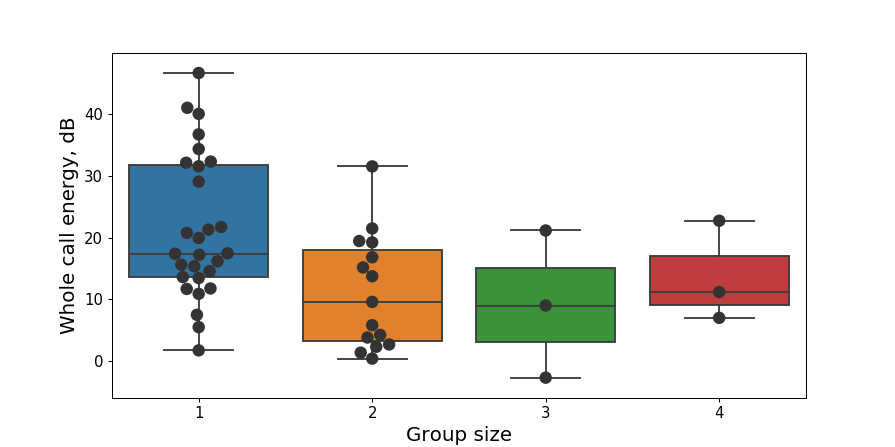

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [86]:
variable = 'call_dB_energy'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Whole call energy, dB', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)

<IPython.core.display.Javascript object>


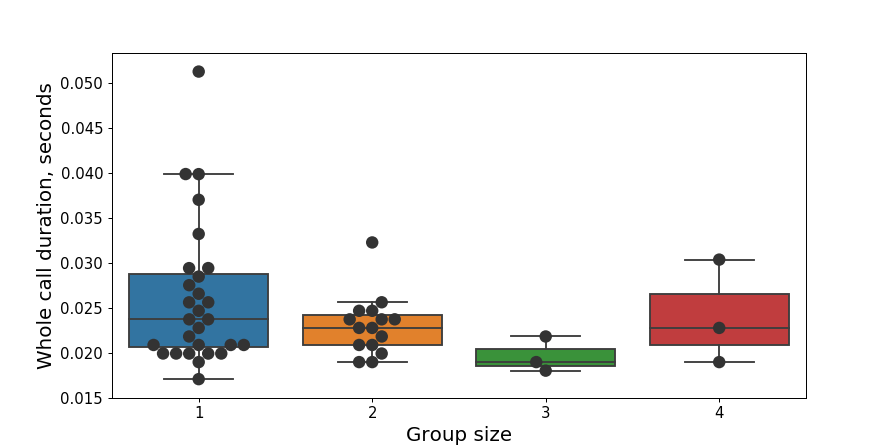

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [87]:
variable = 'call_duration'
plt.figure(figsize=(10,5))
sns.boxplot(x='number_of_bats',y=variable,data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y=variable,data=msmts_df, size=10, color="0.2");
plt.yticks(fontsize=12)
plt.ylabel('Whole call duration, seconds', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.xticks(fontsize=12)

<IPython.core.display.Javascript object>


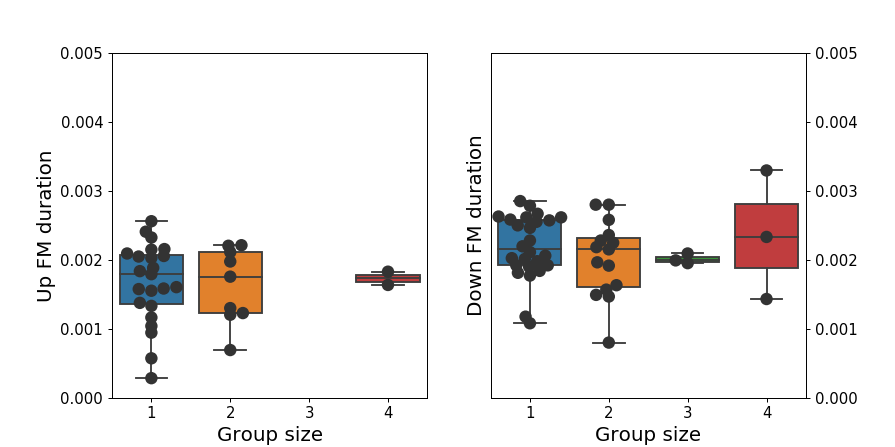

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [88]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.boxplot(x='number_of_bats',y='upfm_duration',data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y='upfm_duration',data=msmts_df, size=10, color="0.2");
plt.ylabel('Up FM duration', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.ylim(0,0.005)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
a1 = plt.subplot(122)
sns.boxplot(x='number_of_bats',y='downfm_duration',data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y='downfm_duration',data=msmts_df, size=10, color="0.2");
plt.ylabel('Down FM duration', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.ylim(0,0.005)
a1.yaxis.tick_right()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

In [89]:
msmts_df['upfm_terminal_frequency']

0      91015.625000
2      91569.767442
5      94357.976654
7      92485.549133
8      88607.594937
9      91836.734694
11     87476.099426
13    101694.915254
14     95386.533666
15     95070.422535
16     93843.843844
17     95192.307692
19     91382.575758
20              NaN
21     88378.906250
22              NaN
23              NaN
24     95328.282828
25     92657.342657
26     93949.044586
27     92512.908778
28     90206.185567
31              NaN
32              NaN
33     92047.930283
35     89285.714286
37     92005.076142
38              NaN
39              NaN
40     88919.925512
41     91715.976331
44              NaN
45     88169.642857
46     93642.611684
49     76225.045372
50     89574.898785
51              NaN
53     88870.431894
54     92824.601367
55              NaN
56              NaN
57              NaN
59     90262.582057
60     92833.876221
61              NaN
62     89242.053790
63              NaN
64              NaN
66     93076.923077
Name: upfm_terminal_

<IPython.core.display.Javascript object>


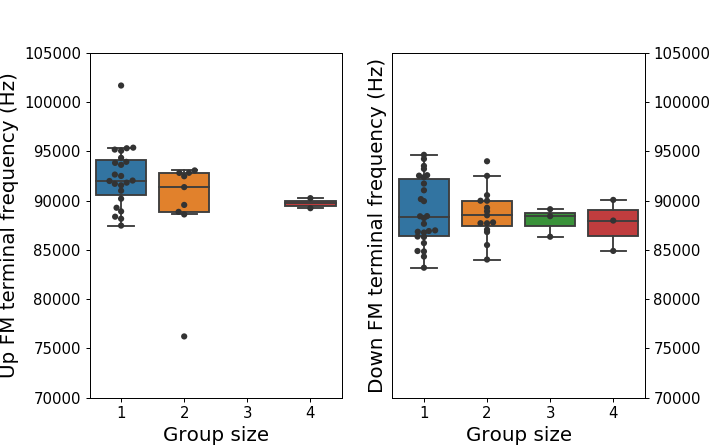

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

In [90]:
plt.figure(figsize=(8,5))
plt.subplot(121)
sns.boxplot(x='number_of_bats',y='upfm_terminal_frequency',data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y='upfm_terminal_frequency',data=msmts_df, size=5, color="0.2");
plt.ylabel('Up FM terminal frequency (Hz)', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.ylim(70000,105000)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
a1 = plt.subplot(122)
sns.boxplot(x='number_of_bats',y='downfm_terminal_frequency',data=msmts_df, showfliers=False);
sns.swarmplot(x='number_of_bats',y='downfm_terminal_frequency',data=msmts_df, size=5, color="0.2");
plt.ylabel('Down FM terminal frequency (Hz)', fontsize=16)
plt.xlabel('Group size', fontsize=16)
plt.ylim(70000,105000)
a1.yaxis.tick_right()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

Version used to generate data for Etho2020 @ Tübingen. 2020-02-14